In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import genetools
import scanpy as sc
from IPython.display import display, Markdown
from typing import List, Tuple, Dict
from typing import Optional
import os
import gc
from pathlib import Path

from malid import config, io, logger
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    SampleWeightStrategy,
    CrossValidationSplitStrategy,
    healthy_label,
)
from malid.trained_model_wrappers import BlendingMetamodel
import crosseval
from crosseval import FeaturizedData
from malid.external.adjust_model_decision_thresholds import (
    AdjustedProbabilitiesDerivedModel,
)
from kdict import kdict
from slugify import slugify

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We only support one split strategy here.
assert (
    config.cross_validation_split_strategy
    == CrossValidationSplitStrategy.in_house_peak_disease_timepoints
)

In [3]:
gene_loci = config.gene_loci_used
print(gene_loci)

GeneLocus.BCR|TCR


In [4]:
evaluation_target = TargetObsColumnEnum.disease
# Also use an alternate evaluation_target that support demographics_only metamodel
evaluation_target_with_demographics = (
    TargetObsColumnEnum.disease_all_demographics_present
)

In [5]:
metamodel_names = ["ridge_cv", "elasticnet_cv", "lasso_cv", "rf_multiclass"]
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"
metamodel_fold_label_test = "external"  # what we evaluate on

In [6]:
import dataclasses


def convert_abstentions_to_healthy(
    model_single_fold_performance: crosseval.ModelSingleFoldPerformance,
    fill_in_class: str,
) -> crosseval.ModelSingleFoldPerformance:
    """Convert abstentions to healthy with Pr(healthy) = 1, all other class probabilities zero. Healthy label indicated by fill_in_class parameter."""
    # Based on how we do the inverse in crosseval.ModelSingleFoldPerformance.apply_abstention_mask()
    return dataclasses.replace(
        model_single_fold_performance,
        # Pass in null InitVars to make a copy
        clf=None,
        X_test=None,
        # Make changes
        y_true=np.hstack(
            [
                model_single_fold_performance.y_true,
                model_single_fold_performance.test_abstentions,
            ]
        ),
        y_pred=np.hstack(
            [
                model_single_fold_performance.y_pred,
                [fill_in_class] * model_single_fold_performance.n_abstentions,
            ]
        ),
        X_test_shape=(
            model_single_fold_performance.X_test_shape[0]
            + model_single_fold_performance.n_abstentions,
            model_single_fold_performance.X_test_shape[1],
        )
        if model_single_fold_performance.X_test_shape is not None
        else None,
        # Remove logits, not sure how to update them:
        y_decision_function=None,
        # Update y_preds_proba:
        # TODO: In binary setting, are y_preds_proba a single column rather than 2 columns?
        y_preds_proba=pd.concat(
            [
                pd.DataFrame(
                    model_single_fold_performance.y_preds_proba,
                    columns=model_single_fold_performance.class_names,
                ),
                pd.DataFrame(
                    {fill_in_class: [1.0] * model_single_fold_performance.n_abstentions}
                ).reindex(
                    columns=model_single_fold_performance.class_names, fill_value=0.0
                ),
            ],
            axis=0,
        )
        if model_single_fold_performance.y_preds_proba is not None
        else None,
        test_metadata=pd.concat(
            [
                model_single_fold_performance.test_metadata,
                model_single_fold_performance.test_abstention_metadata,
            ],
            axis=0,
        ),
        test_sample_weights=np.hstack(
            [
                model_single_fold_performance.test_sample_weights,
                model_single_fold_performance.test_abstention_sample_weights,
            ]
        )
        if model_single_fold_performance.test_sample_weights is not None
        and model_single_fold_performance.test_abstention_sample_weights is not None
        else None,
        test_abstentions=None,  # This triggers default factory
        test_abstention_metadata=None,  # This triggers default factory
        test_abstention_sample_weights=None,
        # All other fields stay the same
    )

In [7]:
def run(
    gene_locus: GeneLocus,
    classification_target: TargetObsColumnEnum,
    output_dir: Optional[Path] = None,
    metamodel_flavor: str = "default",
) -> Tuple[crosseval.ExperimentSetGlobalPerformance, FeaturizedData]:
    """Load and run metamodel for a single locus or multiple loci"""
    display(
        Markdown(
            f"## {gene_locus}, {classification_target}, metamodel flavor {metamodel_flavor}"
        )
    )

    # Load external cohort data, which at the moment has completely different specimens in the BCR vs TCR sets, so we will not use BCR+TCR metamodels.
    GeneLocus.validate_single_value(gene_locus)
    adata = io.load_fold_embeddings(
        fold_id=-1,
        fold_label=metamodel_fold_label_test,
        gene_locus=gene_locus,
        target_obs_column=classification_target,
    )

    # Load the metamodels
    clfs = {}
    for metamodel_name in metamodel_names:
        clfs[metamodel_name] = BlendingMetamodel.from_disk(
            fold_id=-1,
            metamodel_name=metamodel_name,
            base_model_train_fold_name=base_model_train_fold_name,
            metamodel_fold_label_train=metamodel_fold_label_train,
            gene_locus=gene_locus,
            target_obs_column=classification_target,
            metamodel_flavor=metamodel_flavor,
        )

    # Load data and featurize.
    # Assumption: all metamodel names for the same metamodel flavor will produce the same featurization, because they all use the same base models and feature transforms.
    # So we only need to featurize once per metamodel flavor.
    # Just choose the first loaded metamodel and featurize with it. It will be the same as featurizing with a different loaded metamodel.
    featurized = next(iter(clfs.values())).featurize({gene_locus: adata})
    # Handle abstention
    if featurized.X.shape[0] == 0:
        raise ValueError("All abstained")

    # garbage collect
    del adata
    gc.collect()

    ## Decision threshold tuning:
    # Split parts of featurized data for optional decision threshold tuning.
    # (There's no splitting or tuning in the "untuned.all_data" results, if you want to ignore this.)

    # Set a random seed for reproducibility
    np.random.seed(42)

    # 'featurized' is a single FeaturizedData object for all participants
    metadata = featurized.metadata
    X = featurized.X
    y = featurized.y
    sample_names = featurized.sample_names

    # Extract unique participant labels
    participant_labels = metadata["participant_label"].unique()

    # Map each participant to their specimen indices (ilocs)
    participant_to_specimen_indices = {
        participant: np.where(metadata["participant_label"] == participant)[0]
        for participant in participant_labels
    }

    # Map each disease to participant labels
    disease_to_participants = (
        metadata.groupby(classification_target.value.obs_column_name)[
            "participant_label"
        ]
        .unique()
        .to_dict()
    )

    # Calculate the number of participants to take for validation per disease
    # Choose how many we will split off for validation. Take 30% of smallest class (measured by # unique patients) - constrained to be between 2 to 10 samples per class.
    amount_to_take = {
        disease: int(min(max(0.3 * len(participants), 2), 10))
        for disease, participants in disease_to_participants.items()
    }
    logger.info(
        f"{gene_locus}, {classification_target}, metamodel flavor {metamodel_flavor}: splitting off {amount_to_take} participants per class for decision threshold tuning."
    )

    # Split participants into validation and test sets for each disease
    validation_indices, test_indices = [], []

    for disease, participants in disease_to_participants.items():
        np.random.shuffle(participants)
        validation_participants = participants[: amount_to_take[disease]]
        test_participants = participants[amount_to_take[disease] :]

        for participant in validation_participants:
            validation_indices.append(participant_to_specimen_indices[participant])

        for participant in test_participants:
            test_indices.append(participant_to_specimen_indices[participant])

    validation_indices = np.hstack(validation_indices)
    test_indices = np.hstack(test_indices)

    # Sanity checks
    assert len(set(validation_indices).intersection(test_indices)) == 0
    assert len(validation_indices) + len(test_indices) == len(metadata)

    # Convert indices to arrays
    validation_indices = np.array(validation_indices)
    test_indices = np.array(test_indices)

    # Extract validation and test sets
    X_validation = (
        X.iloc[validation_indices]
        if isinstance(X, pd.DataFrame)
        else X[validation_indices]
    )
    y_validation = (
        y.iloc[validation_indices]
        if isinstance(y, pd.Series)
        else y[validation_indices]
    )
    metadata_validation = metadata.iloc[validation_indices]
    sample_names_validation = None
    if sample_names is not None:
        sample_names_validation = (
            sample_names.iloc[validation_indices]
            if isinstance(sample_names, pd.Series)
            else sample_names[validation_indices]
        )

    X_test = X.iloc[test_indices] if isinstance(X, pd.DataFrame) else X[test_indices]
    y_test = y.iloc[test_indices] if isinstance(y, pd.Series) else y[test_indices]
    metadata_test = metadata.iloc[test_indices]
    sample_names_test = None
    if sample_names is not None:
        sample_names_test = (
            sample_names.iloc[test_indices]
            if isinstance(sample_names, pd.Series)
            else sample_names[test_indices]
        )

    # Create FeaturizedData objects for validation and test. Add all abstentions to test set.
    featurized_validation = FeaturizedData(
        X=X_validation,
        y=y_validation,
        sample_names=sample_names_validation,
        metadata=metadata_validation,
    )
    featurized_test = FeaturizedData(
        X=X_test,
        y=y_test,
        sample_names=sample_names_test,
        metadata=metadata_test,
        abstained_sample_names=featurized.abstained_sample_names,
        abstained_sample_metadata=featurized.abstained_sample_metadata,
        abstained_sample_y=featurized.abstained_sample_y,
    )

    ## Run each metamodel

    # Create final result containers, for all metamodels
    results = crosseval.ExperimentSet()

    for metamodel_name, clf in clfs.items():
        # Tune model
        clf_tuned = AdjustedProbabilitiesDerivedModel.adjust_model_decision_thresholds(
            model=clf,
            X_validation=featurized_validation.X,
            y_validation_true=featurized_validation.y,
        )

        # Do evaluation
        for transformed_clf, transformed_model_name, fd in zip(
            [clf, clf, clf_tuned],
            [
                metamodel_name + ".untuned.all_data",
                metamodel_name + ".untuned.test_subset",
                metamodel_name + ".tuned.test_subset",
            ],
            [featurized, featurized_test, featurized_test],
        ):
            results.add(
                crosseval.ModelSingleFoldPerformance(
                    model_name=transformed_model_name,
                    fold_id=-1,
                    y_true=fd.y,
                    clf=transformed_clf,
                    X_test=fd.X,
                    fold_label_train=metamodel_fold_label_train,
                    fold_label_test=metamodel_fold_label_test,
                    test_metadata=fd.metadata,
                    test_abstentions=fd.abstained_sample_y,
                    test_abstention_metadata=fd.abstained_sample_metadata,
                )
            )

    # Convert abstentions to healthy with Pr(healthy) = 1, all other class probabilities zero. Add these as extra model names.
    original_keys = list(results.model_outputs.keys())
    for key in original_keys:  # Don't iterate over dict that's actively changing
        original_model_single_fold_performance = results.model_outputs[key]
        if original_model_single_fold_performance.n_abstentions == 0:
            # No abstentions. Skip.
            continue
        modified_model_single_fold_performance = convert_abstentions_to_healthy(
            model_single_fold_performance=original_model_single_fold_performance,
            fill_in_class=healthy_label,
        )
        # Also adjust model name
        modified_model_single_fold_performance = dataclasses.replace(
            modified_model_single_fold_performance,
            model_name=modified_model_single_fold_performance.model_name
            + ".abstentions_converted_to_healthy",
        )
        # Store the modified version under its new model name
        results.add(modified_model_single_fold_performance)

    results = results.summarize()
    combined_stats = results.get_model_comparison_stats(sort=True)

    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
        results.export_all_models(
            func_generate_classification_report_fname=lambda model_name: output_dir
            / f"classification_report.{model_name}.txt",
            func_generate_confusion_matrix_fname=lambda model_name: output_dir
            / f"confusion_matrix.{model_name}.png",
            dpi=300,
        )
        combined_stats.to_csv(
            output_dir / "compare_model_scores.tsv",
            sep="\t",
        )

    display(combined_stats)
    for model_name, model_perf in results.model_global_performances.items():
        print(model_name)
        print(model_perf.full_report())
        display(model_perf.confusion_matrix_fig())
        print()
        print("*" * 60)
        print()

    return results, featurized

# External cohorts similar to our sequencing process

## GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor default

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.-1.external.h5ad -> /srv/scratch/maximz/cache/517aa0fb1febeb2215f5736b77680c83007855eac07b09ee41bc4af5.-1.external.h5ad", "time": "2024-02-22T19:51:04.803554"}


Only considering the two last: ['.external', '.h5ad'].


Only considering the two last: ['.external', '.h5ad'].


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 672 / 9360 = 7.18%", "time": "2024-02-22T20:12:12.734946"}


{"message": "GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor default: splitting off {'Healthy/Background': 2, 'Covid19': 2} participants per class for decision threshold tuning.", "time": "2024-02-22T20:12:54.577507"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.846079"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.848071"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.850045"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.851893"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.857347"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.859356"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.861412"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.863402"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.868622"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.870606"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.872554"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.874472"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.878462"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.880406"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.882334"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.884233"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.914472"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.915910"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.917566"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.919404"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.924124"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.925887"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.927686"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.929503"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.934352"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.935985"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.937643"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.939444"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.943144"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.945023"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.946872"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.948726"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.977384"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.978741"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.980364"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.981988"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.986939"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.988762"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:55.990436"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:55.992247"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:55.996710"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:55.998447"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.000278"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.001914"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.005626"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.007472"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.009295"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.011089"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.041089"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.042536"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.044187"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.045866"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.050422"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.052260"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.053999"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.055807"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.060543"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.062282"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.064025"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.065848"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.069432"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.071259"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.072991"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.074774"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.102140"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.104161"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.105888"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.107739"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.112594"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.114221"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.116057"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.117916"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.122645"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.124328"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.125964"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.127754"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.131369"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.133084"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.134746"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.136488"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.164694"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.166643"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.168399"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.170058"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.174989"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.176854"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.178759"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.182258"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.187149"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.189035"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.190822"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.192593"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.196296"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.198026"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.199755"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.201585"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.231047"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.232501"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.234148"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.235963"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.240958"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.242672"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.244521"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.246186"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.250762"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.252560"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.254192"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.255993"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.259575"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.261295"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.263023"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.264819"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.292909"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.294315"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.295959"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.297810"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.302355"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.304214"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.305905"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.307725"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.312140"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.313984"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.315648"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.317473"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.321037"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.322799"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.326328"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.328276"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.354938"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.356790"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.358532"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.360427"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.365371"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.367001"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.368815"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.370509"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.374883"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.376618"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.378284"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.379946"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.383607"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.385463"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.387182"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.389052"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.416328"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.417960"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.419664"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.421423"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.426126"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.427899"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.429746"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.431555"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.436097"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.437941"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.439759"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.441576"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.445321"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.447095"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.448947"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.450747"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.482483"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.483916"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.485591"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.487454"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.492169"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.493895"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.495712"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.497402"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.501781"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.503553"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.505373"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.507094"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.510775"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.512555"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.514183"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.515982"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.544291"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.545739"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.547406"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.549270"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.554014"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.555782"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.557709"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.559505"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.564161"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.565851"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.567602"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.569400"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:12:56.573063"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:12:56.574887"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:12:56.576576"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:12:56.578236"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.all_data            1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.all_data           1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.all_data          0.692 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.778 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.846 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.889 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.8

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.692 +/- 0.000 (in 1 folds)
MCC: 0.577 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.692
MCC: 0.577

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.50      0.67         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.69        13
         macro avg       0.50      0.34      0.40        13
      weighted avg       1.00      0.69      0.80        13



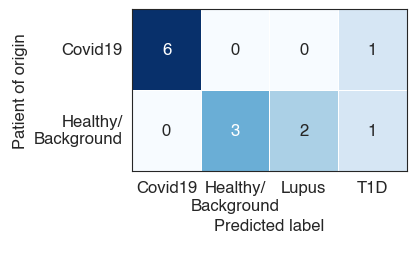


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.778 +/- 0.000 (in 1 folds)
MCC: 0.671 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.778
MCC: 0.671

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.50      0.67         4
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.78         9
         macro avg       0.50      0.38      0.42         9
      weighted avg       1.00      0.78      0.85         9



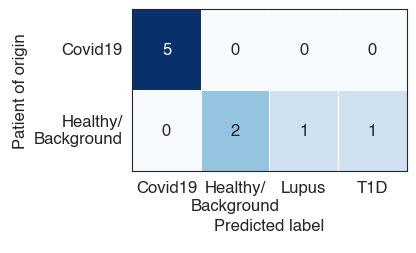


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



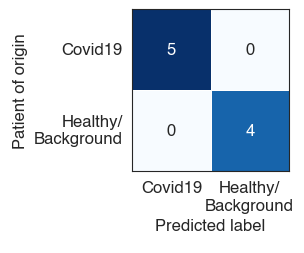


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.752 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.752

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.83      0.91         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.50      0.42      0.46        13
      weighted avg       1.00      0.85      0.92        13



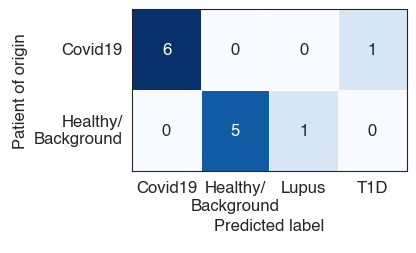


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



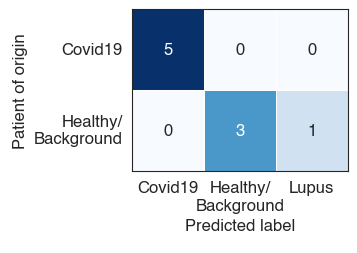


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



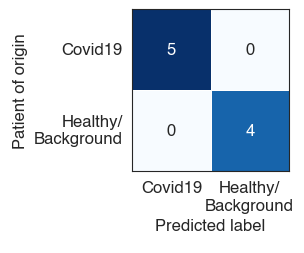


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.752 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.752

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.83      0.91         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.50      0.42      0.46        13
      weighted avg       1.00      0.85      0.92        13



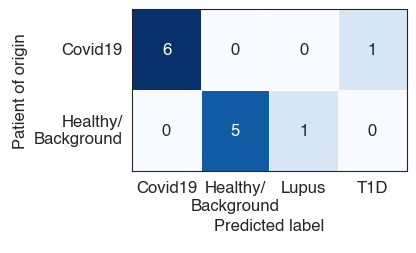


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



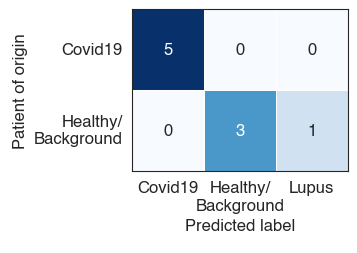


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



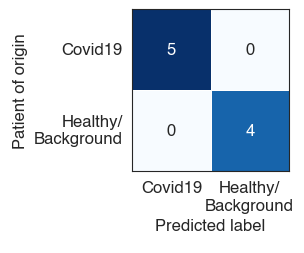


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.724 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.724

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.83      0.83      0.83         6
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.61      0.56      0.59        13
      weighted avg       0.92      0.85      0.88        13



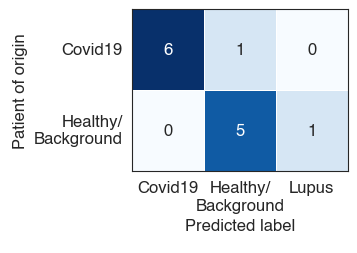


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



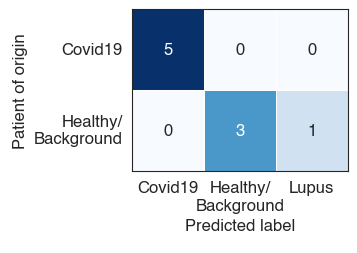


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.778 +/- 0.000 (in 1 folds)
MCC: 0.598 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.778
MCC: 0.598

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      1.00      0.83         5
Healthy/Background       1.00      0.50      0.67         4

          accuracy                           0.78         9
         macro avg       0.86      0.75      0.75         9
      weighted avg       0.84      0.78      0.76         9



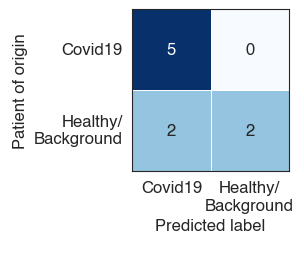


************************************************************



## Metamodel with Models 1 + 3 only for comparison

## GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_sequence_model

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 672 / 9360 = 7.18%", "time": "2024-02-22T20:31:57.986608"}


{"message": "GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_sequence_model: splitting off {'Healthy/Background': 2, 'Covid19': 2} participants per class for decision threshold tuning.", "time": "2024-02-22T20:32:36.355502"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.407733"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.409777"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.411517"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.413214"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.417588"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.419481"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.421320"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.423123"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.427822"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.429556"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.431354"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.433159"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.437001"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.438694"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.440485"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.442094"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.474983"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.476602"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.478259"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.479872"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.484227"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.485874"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.487681"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.489526"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.494075"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.495839"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.497697"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.499547"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.503374"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.505287"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.507186"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.509086"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.537307"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.538695"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.540316"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.541923"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.546337"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.547925"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.549773"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.551428"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.561589"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.563443"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.565387"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.567454"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.572028"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.574143"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.576189"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.578262"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.609292"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.610709"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.612398"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.614056"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.618402"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.620266"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.621996"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.623765"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.628151"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.630047"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.631833"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.633565"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.637262"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.639013"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.640811"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.642522"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.670411"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.672125"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.673804"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.675593"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.679514"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.681208"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.682848"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.684544"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.688346"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.690037"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.691682"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.693308"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.696438"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.698112"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.699743"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.701365"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.730039"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.731464"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.733259"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.734912"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.739113"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.740667"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.742295"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.743891"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.747646"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.749357"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.751006"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.752643"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.755910"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.757632"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.759472"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.761319"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.790341"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.791708"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.793344"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.794946"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.798826"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.800479"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.802094"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.803713"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.807600"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.809251"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.810865"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.812510"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.815611"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.817291"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.818902"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.820535"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.846474"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.847896"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.849574"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.851197"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.855086"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.856755"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.858383"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.860046"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.864925"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.866707"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.873929"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.875903"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.879576"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.881273"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.883007"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.884811"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.912979"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.914360"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.915994"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.917605"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.922228"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.923865"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.925703"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.927534"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.932406"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.934003"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.935690"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.937373"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.940941"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.942712"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.944526"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.946179"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.973608"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.974974"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.976607"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.978241"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.982528"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.984270"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.985917"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.987710"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:37.992599"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:37.994345"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:37.996046"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:37.997784"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.001459"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.003260"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.005095"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.006762"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.036041"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.037511"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.039167"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.040787"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.045141"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.046678"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.048618"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.050133"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.054663"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.056562"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.058268"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.059956"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.063646"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.065387"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.067150"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.068984"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.096032"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.097637"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.099255"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.100983"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.104813"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.106466"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.108083"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.109708"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.113544"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.115219"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.116895"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.118560"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:32:38.122204"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:32:38.124119"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:32:38.126014"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:32:38.127828"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.952 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.952 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.925 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.925 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.881 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.881 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.952 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.952 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.925 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.925 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.881 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.881 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.948 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.948 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.917 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.818 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.842 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.948 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.948 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.917 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.818 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.842 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.test_subset       0.556 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.556 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.778 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.556 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.778 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.4

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.881 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.881 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.818 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.818 +/- 0.000 (in 1 folds)
Accuracy: 0.462 +/- 0.000 (in 1 folds)
MCC: 0.371 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.462
MCC: 0.371

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.00      0.00      0.00         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.46        13
         macro avg       0.20      0.17      0.18        13
      weighted avg       0.54      0.46      0.50        13



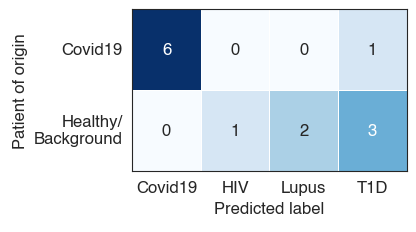


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.556 +/- 0.000 (in 1 folds)
MCC: 0.447 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.556
MCC: 0.447

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.00      0.00      0.00         4
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.56         9
         macro avg       0.20      0.20      0.20         9
      weighted avg       0.56      0.56      0.56         

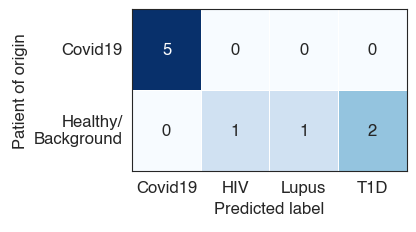


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



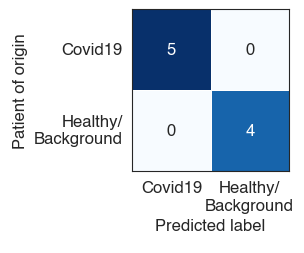


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.952 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.952 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.948 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.948 +/- 0.000 (in 1 folds)
Accuracy: 0.462 +/- 0.000 (in 1 folds)
MCC: 0.378 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.462
MCC: 0.378

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.00      0.00      0.00         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.46        13
         macro avg       0.25      0.21      0.23        13
      weighted avg       0.54      0.46      0.50        13



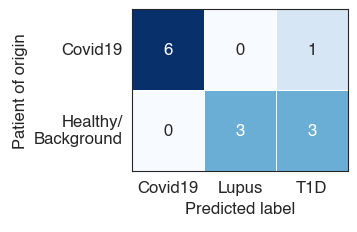


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.556 +/- 0.000 (in 1 folds)
MCC: 0.456 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.556
MCC: 0.456

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       0.00      0.00      0.00         4
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.56         9
         macro avg       0.25      0.25      0.25         9
      weighted avg       0.56      0.56      0.56         9



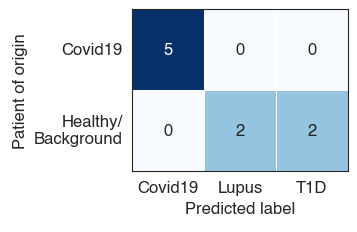


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.778 +/- 0.000 (in 1 folds)
MCC: 0.598 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.778
MCC: 0.598

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      1.00      0.83         5
Healthy/Background       1.00      0.50      0.67         4

          accuracy                           0.78         9
         macro avg       0.86      0.75      0.75         9
      weighted avg       0.84      0.78      0.76         9



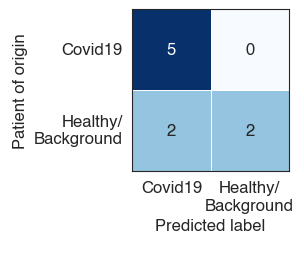


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.952 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.952 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.948 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.948 +/- 0.000 (in 1 folds)
Accuracy: 0.462 +/- 0.000 (in 1 folds)
MCC: 0.378 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.462
MCC: 0.378

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.00      0.00      0.00         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.46        13
         macro avg       0.25      0.21      0.23        13
      weighted avg       0.54      0.46      0.50        13



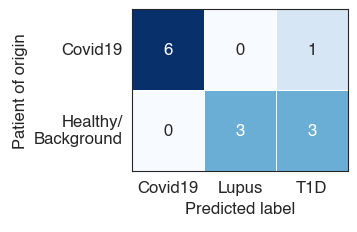


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.556 +/- 0.000 (in 1 folds)
MCC: 0.456 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.556
MCC: 0.456

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       0.00      0.00      0.00         4
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.56         9
         macro avg       0.25      0.25      0.25         9
      weighted avg       0.56      0.56      0.56         9



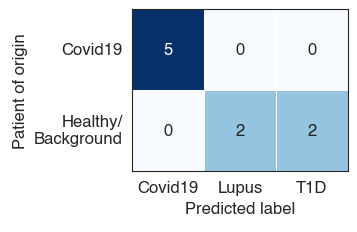


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.778 +/- 0.000 (in 1 folds)
MCC: 0.598 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.778
MCC: 0.598

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      1.00      0.83         5
Healthy/Background       1.00      0.50      0.67         4

          accuracy                           0.78         9
         macro avg       0.86      0.75      0.75         9
      weighted avg       0.84      0.78      0.76         9



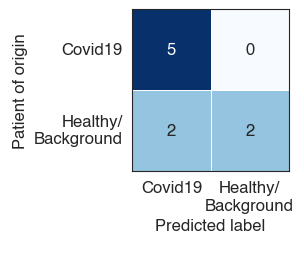


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.881 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.881 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.842 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.842 +/- 0.000 (in 1 folds)
Accuracy: 0.692 +/- 0.000 (in 1 folds)
MCC: 0.526 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.692
MCC: 0.526

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.75      0.50      0.60         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.69        13
         macro avg       0.44      0.34      0.38        13
      weighted avg       0.88      0.69      0.77        13



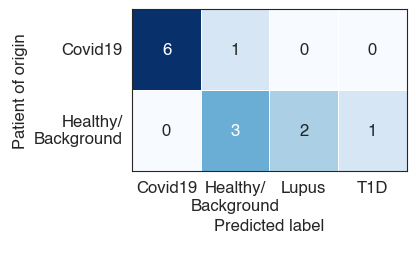


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.925 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.925 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.917 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.917 +/- 0.000 (in 1 folds)
Accuracy: 0.667 +/- 0.000 (in 1 folds)
MCC: 0.559 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.667
MCC: 0.559

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.25      0.40         4
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.67         9
         macro avg       0.50      0.31      0.35         9
      weighted avg       1.00      0.67      0.73         9



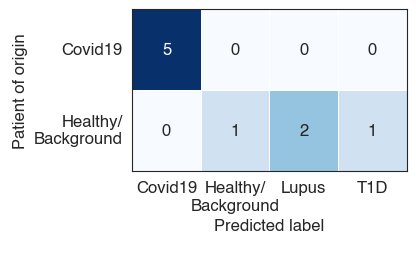


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.925 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.925 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.917 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.917 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



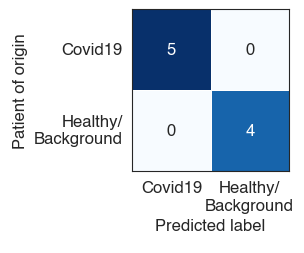


************************************************************



## Metamodel with Models 1 + 2 only for comparison

## GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_convergent_cluster_model

{"message": "GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_convergent_cluster_model: splitting off {'Healthy/Background': 2, 'Covid19': 2} participants per class for decision threshold tuning.", "time": "2024-02-22T20:34:14.351462"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.096276"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.098311"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.099989"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.101666"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.105490"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.107155"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.108789"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.110406"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.114289"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.116098"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.118005"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.119902"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.123900"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.125844"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.127779"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.129715"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.162854"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.164338"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.166012"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.167802"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.171706"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.173429"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.175045"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.176819"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.181719"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.183660"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.185571"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.187462"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.191432"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.193370"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.195292"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.197218"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.226598"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.228147"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.229779"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.231382"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.235340"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.237043"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.238849"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.240644"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.245240"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.246852"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.248662"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.250266"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.253928"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.255755"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.257604"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.259484"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.289917"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.291457"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.293099"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.294709"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.299120"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.303706"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.305645"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.307357"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.311497"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.313248"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.314954"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.316693"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.320333"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.322246"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.323984"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.325892"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.364058"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.365484"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.367149"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.368816"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.374677"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.376463"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.378298"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.380174"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.385171"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.387202"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.389012"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.390767"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.394632"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.396576"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.398401"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.400285"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.429440"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.430818"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.432486"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.434147"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.438022"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.439691"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.441400"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.443076"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.447595"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.449305"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.451100"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.455714"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.459476"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.461420"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.463097"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.464816"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.491839"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.493443"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.495153"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.496813"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.501018"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.502534"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.504141"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.505769"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.509672"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.511319"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.512979"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.514645"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.517761"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.519566"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.521336"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.523202"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.551519"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.553114"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.554973"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.556610"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.560558"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.562244"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.563861"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.565493"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.569866"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.571489"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.573200"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.574899"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.578582"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.580360"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.582039"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.583873"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.614336"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.615706"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.617356"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.618993"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.623567"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.625441"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.627239"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.629053"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.633729"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.635463"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.637158"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.638855"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.642526"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.644309"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.645976"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.647784"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.674693"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.676300"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.678132"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.679629"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.683754"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.685607"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.687409"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.689252"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.694106"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.695853"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.697597"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.699300"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.702891"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.704661"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.706315"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.708100"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.738272"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.739734"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.741425"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.743064"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.747114"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.748809"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.750438"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.752040"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.756589"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.758359"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.760152"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.761877"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.765558"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.767264"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.768948"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.770650"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.797807"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.799420"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.801096"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.802955"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.807051"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.808897"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.810525"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.812127"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.817016"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.818784"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.820506"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.822190"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:34:16.825906"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:34:16.827791"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:34:16.829589"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:34:16.831420"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.976 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.976 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.976 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.976 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.test_subset       0.889 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.846 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.889 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.846 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.8

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
Accuracy: 0.769 +/- 0.000 (in 1 folds)
MCC: 0.660 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.769
MCC: 0.660

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.67      0.80         6
         Influenza       0.00      0.00      0.00         0
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.77        13
         macro avg       0.50      0.38      0.43        13
      weighted avg       1.00      0.77      0.87        13



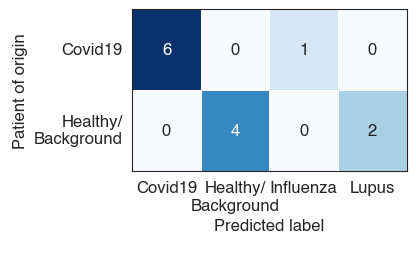


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



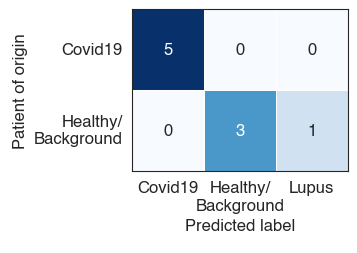


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



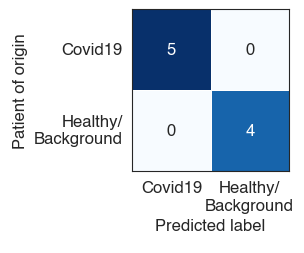


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.752 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.752

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.83      0.91         6
         Influenza       0.00      0.00      0.00         0
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.50      0.42      0.46        13
      weighted avg       1.00      0.85      0.92        13



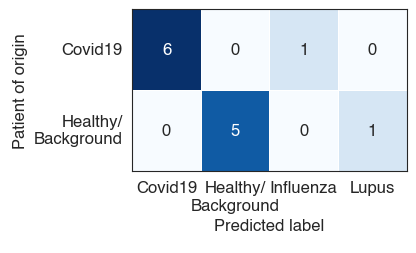


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



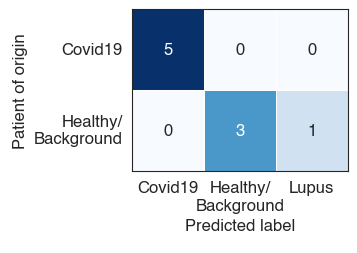


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



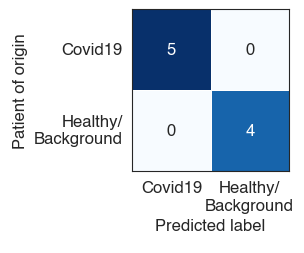


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.752 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.752

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.83      0.91         6
         Influenza       0.00      0.00      0.00         0
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.50      0.42      0.46        13
      weighted avg       1.00      0.85      0.92        13



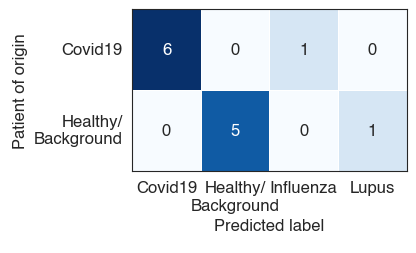


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



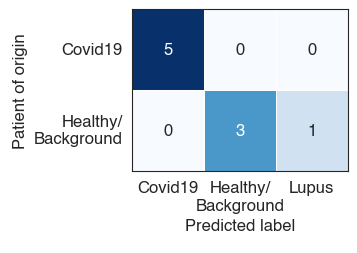


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



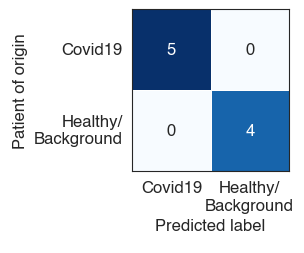


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.846 +/- 0.000 (in 1 folds)
MCC: 0.752 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.846
MCC: 0.752

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.83      0.91         6
         Influenza       0.00      0.00      0.00         0
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.85        13
         macro avg       0.50      0.42      0.46        13
      weighted avg       1.00      0.85      0.92        13



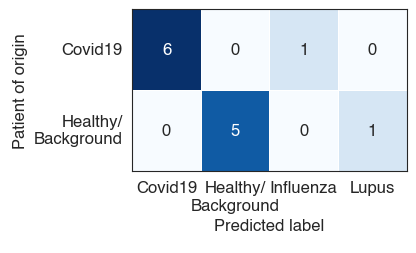


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



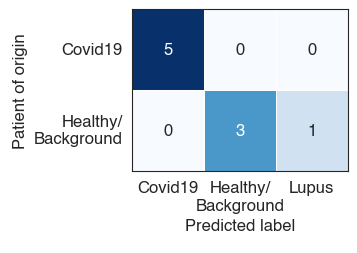


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.791 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.791

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      1.00      0.91         5
Healthy/Background       1.00      0.75      0.86         4

          accuracy                           0.89         9
         macro avg       0.92      0.88      0.88         9
      weighted avg       0.91      0.89      0.89         9



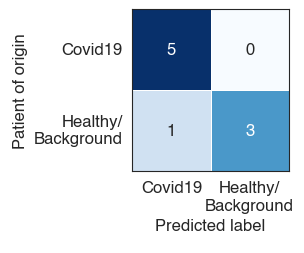


************************************************************



## Metamodel with Models 2 + 3 only for comparison

## GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_convergent_cluster_model_sequence_model

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 672 / 9360 = 7.18%", "time": "2024-02-22T20:52:18.971996"}


{"message": "GeneLocus.BCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_convergent_cluster_model_sequence_model: splitting off {'Healthy/Background': 2, 'Covid19': 2} participants per class for decision threshold tuning.", "time": "2024-02-22T20:52:56.506752"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.146017"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.147950"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.149690"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.151431"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.155444"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.157092"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.158850"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.160455"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.164450"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.166081"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.167685"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.169262"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.173091"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.174951"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.176766"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.178424"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.207199"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.208943"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.210738"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.213808"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.217918"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.219554"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.221183"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.222792"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.226920"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.228539"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.230105"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.231874"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.235255"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.237165"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.238832"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.240593"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.268888"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.270260"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.271816"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.273597"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.277739"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.279210"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.280795"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.282427"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.287089"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.288799"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.290403"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.292181"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.295709"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.297547"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.299342"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.301136"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.330655"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.332030"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.333655"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.335413"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.339368"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.341105"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.342946"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.344774"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.349303"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.351190"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.356409"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.358385"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.362036"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.363759"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.365466"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.367218"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.394284"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.395682"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.397267"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.399016"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.402737"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.404328"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.405950"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.407700"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.411752"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.413362"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.414920"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.416549"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.419631"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.421250"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.423095"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.424782"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.453247"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.454631"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.456188"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.457934"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.462249"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.463771"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.465375"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.467119"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.471134"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.472727"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.474299"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.475857"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.478960"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.480610"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.482239"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.484157"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.515325"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.516953"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.518592"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.520126"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.524003"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.525656"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.527410"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.528990"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.533483"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.534931"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.536503"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.538125"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.541488"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.543102"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.544928"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.546743"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.576428"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.577835"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.579403"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.581278"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.585333"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.586939"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.588711"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.590269"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.594955"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.596620"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.598262"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.600034"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.603647"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.605471"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.607181"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.608972"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.640962"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.642643"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.644249"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.645838"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.650607"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.652268"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.653909"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.655691"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.660800"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.662537"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.664271"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.665928"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.669778"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.671609"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.673771"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.675782"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.709055"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.710774"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.712472"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.714069"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.719177"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.720939"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.722720"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.724473"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.728900"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.730843"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.732528"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.734201"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.738040"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.739761"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.741660"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.743303"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.771585"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.773418"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.775068"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.777808"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.782931"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.784716"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.786428"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.788226"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.792579"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.794351"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.796177"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.798004"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.801500"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.803188"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.804862"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.806583"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.835923"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.837385"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.838978"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.840757"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.844651"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.846307"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.847973"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.849632"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.854035"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.855904"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.857619"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.859408"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T20:52:57.863051"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:52:57.865104"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:52:57.868628"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T20:52:57.870163"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.976 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.900 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.900 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.893 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.976 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.900 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.900 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.893 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.976 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.906 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.976 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.917 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.906 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.test_subset       0.667 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.889 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.692 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.889 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    1.000 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.692 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.8

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
Accuracy: 0.538 +/- 0.000 (in 1 folds)
MCC: 0.456 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.538
MCC: 0.456

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.17      0.29         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.54        13
         macro avg       0.50      0.26      0.30        13
      weighted avg       1.00      0.54      0.63        13



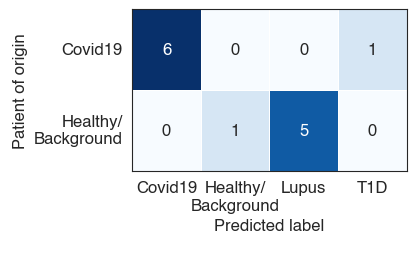


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.667 +/- 0.000 (in 1 folds)
MCC: 0.583 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.667
MCC: 0.583

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.25      0.40         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.67         9
         macro avg       0.67      0.42      0.47         9
      weighted avg       1.00      0.67      0.73         9



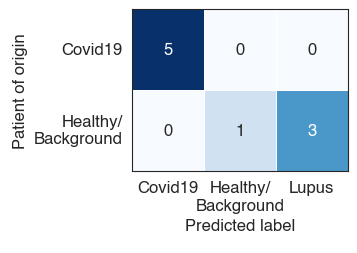


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.791 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.791

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      1.00      0.91         5
Healthy/Background       1.00      0.75      0.86         4

          accuracy                           0.89         9
         macro avg       0.92      0.88      0.88         9
      weighted avg       0.91      0.89      0.89         9



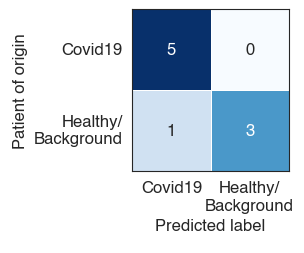


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.692 +/- 0.000 (in 1 folds)
MCC: 0.582 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.692
MCC: 0.582

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.50      0.67         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.69        13
         macro avg       0.50      0.34      0.40        13
      weighted avg       1.00      0.69      0.80        13



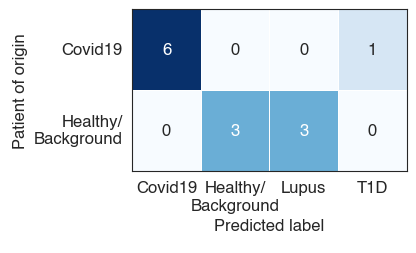


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



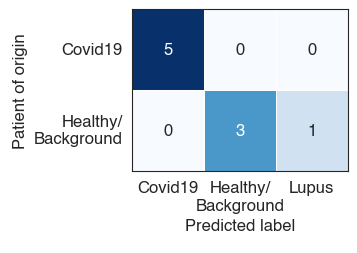


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



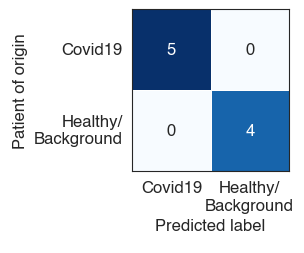


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.692 +/- 0.000 (in 1 folds)
MCC: 0.582 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.692
MCC: 0.582

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       1.00      0.50      0.67         6
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.69        13
         macro avg       0.50      0.34      0.40        13
      weighted avg       1.00      0.69      0.80        13



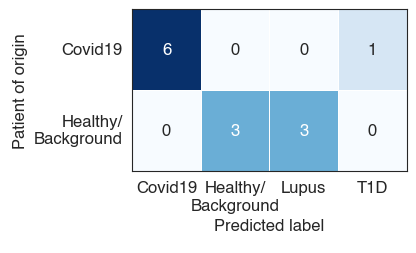


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.889 +/- 0.000 (in 1 folds)
MCC: 0.816 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.889
MCC: 0.816

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.75      0.86         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.89         9
         macro avg       0.67      0.58      0.62         9
      weighted avg       1.00      0.89      0.94         9



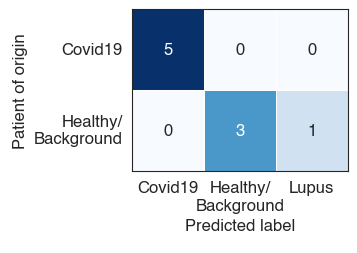


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



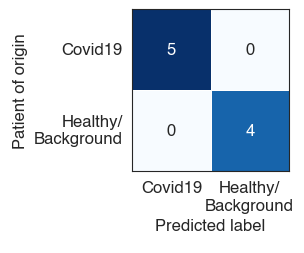


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.893 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.893 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.906 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.906 +/- 0.000 (in 1 folds)
Accuracy: 0.769 +/- 0.000 (in 1 folds)
MCC: 0.621 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.769
MCC: 0.621

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.86      0.92         7
Healthy/Background       0.80      0.67      0.73         6
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.77        13
         macro avg       0.60      0.51      0.55        13
      weighted avg       0.91      0.77      0.83        13



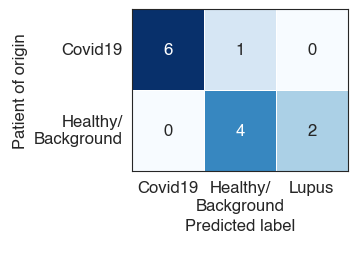


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.900 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.900 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.917 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.917 +/- 0.000 (in 1 folds)
Accuracy: 0.778 +/- 0.000 (in 1 folds)
MCC: 0.685 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.778
MCC: 0.685

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      0.50      0.67         4
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.78         9
         macro avg       0.67      0.50      0.56         9
      weighted avg       1.00      0.78      0.85         9



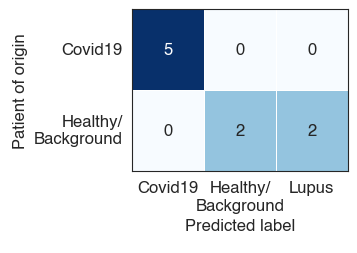


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.900 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.900 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.917 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.917 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         4

          accuracy                           1.00         9
         macro avg       1.00      1.00      1.00         9
      weighted avg       1.00      1.00      1.00         9



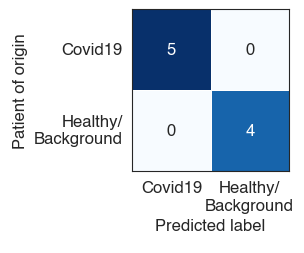


************************************************************



## Demographics-only metamodel for comparison

## GeneLocus.BCR, TargetObsColumnEnum.disease_all_demographics_present, metamodel flavor demographics_only

{"message": "Adding metadata featurizer demographics for TargetObsColumnEnum.disease_all_demographics_present", "time": "2024-02-22T20:53:34.053510"}


{"message": "GeneLocus.BCR, TargetObsColumnEnum.disease_all_demographics_present, metamodel flavor demographics_only: splitting off {'Healthy/Background': 2, 'Covid19': 2} participants per class for decision threshold tuning.", "time": "2024-02-22T20:53:34.633774"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.609335"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.611285"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.615355"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.617004"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.621493"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.622993"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.626088"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.627684"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.655642"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.657145"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.661262"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.662801"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.666892"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.668532"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.671579"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.673251"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.697534"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.699043"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.704646"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.706348"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.710677"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.712252"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.715604"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.717243"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.744682"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.746047"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.749925"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.751552"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.755401"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.757047"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.760122"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.761709"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.786134"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.787648"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.791744"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.793291"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.797567"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.799162"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.802596"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.804416"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.830694"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.834349"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.838472"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.840121"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.844183"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.845891"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.848968"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.850559"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.876342"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.877765"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.882589"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.883926"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.887645"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.889313"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.892860"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.894692"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.922103"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.923564"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.927678"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.929296"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.933590"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.935282"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.938699"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.940483"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.968218"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.969736"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.974058"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.975697"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.979884"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.981535"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:36.984601"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:36.986181"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.013787"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.015219"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.019203"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.020858"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.025121"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.026659"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.029756"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.031335"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.055229"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.057168"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.061645"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.063146"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.067028"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.068670"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.071988"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.073862"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.103382"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.104805"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.109106"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.110725"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.115140"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.116675"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T20:53:37.119874"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T20:53:37.121542"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.all_data            1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.867 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.867 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.800 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.771 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.067 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.067 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.029 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.867 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.867 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.800 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.771 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.067 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.067 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.029 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.all_data           1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.867 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.867 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.825 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.811 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.287 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.287 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.305 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.all_data          1.000 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       1.000 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.867 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.867 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.867 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.825 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.811 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.287 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.287 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.305 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.all_data          0.583 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.625 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         1.000 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.625 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.750 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.625 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.7

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.583 +/- 0.000 (in 1 folds)
MCC: 0.505 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.583
MCC: 0.505

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.57      0.73         7
Healthy/Background       1.00      0.60      0.75         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.58        12
         macro avg       0.67      0.39      0.49        12
      weighted avg       1.00      0.58      0.74        12



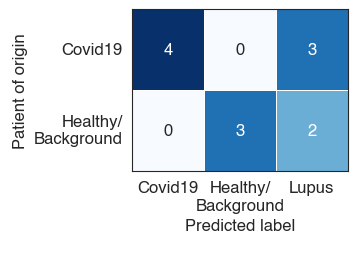


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.535 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.535

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       1.00      0.67      0.80         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.62         8
         macro avg       0.67      0.42      0.52         8
      weighted avg       1.00      0.62      0.77         8



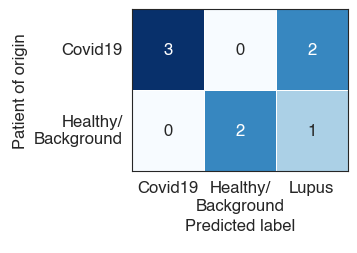


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 1.000 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 1.000 +/- 0.000 (in 1 folds)
Accuracy: 1.000 +/- 0.000 (in 1 folds)
MCC: 1.000 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 1.000
MCC: 1.000

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      1.00      1.00         5
Healthy/Background       1.00      1.00      1.00         3

          accuracy                           1.00         8
         macro avg       1.00      1.00      1.00         8
      weighted avg       1.00      1.00      1.00         8



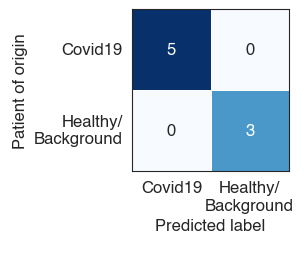


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.771 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.771 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.811 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.811 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: 0.382 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: 0.382

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.43      0.60         7
Healthy/Background       0.75      0.60      0.67         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        12
         macro avg       0.58      0.34      0.42        12
      weighted avg       0.90      0.50      0.63        12



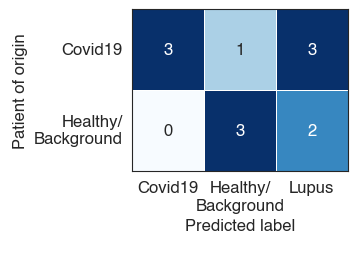


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.535 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.535

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       1.00      0.67      0.80         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.62         8
         macro avg       0.67      0.42      0.52         8
      weighted avg       1.00      0.62      0.77         8



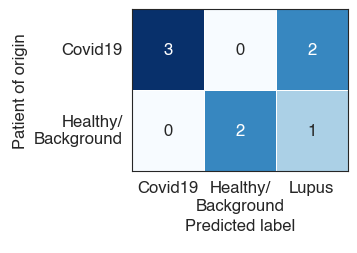


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.600 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.600

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       0.60      1.00      0.75         3

          accuracy                           0.75         8
         macro avg       0.80      0.80      0.75         8
      weighted avg       0.85      0.75      0.75         8



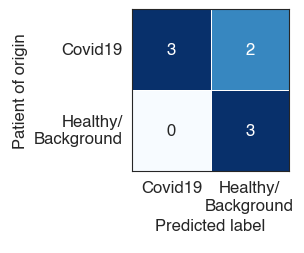


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.800 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.800 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.825 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.825 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: 0.382 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: 0.382

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.43      0.60         7
Healthy/Background       0.75      0.60      0.67         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        12
         macro avg       0.58      0.34      0.42        12
      weighted avg       0.90      0.50      0.63        12



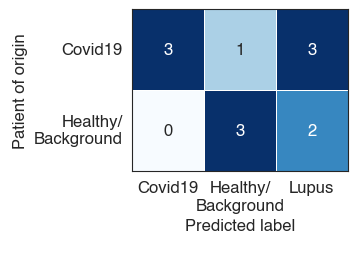


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.535 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.535

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       1.00      0.67      0.80         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.62         8
         macro avg       0.67      0.42      0.52         8
      weighted avg       1.00      0.62      0.77         8



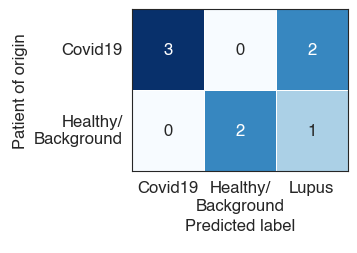


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.867 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.867 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.600 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.600

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75         5
Healthy/Background       0.60      1.00      0.75         3

          accuracy                           0.75         8
         macro avg       0.80      0.80      0.75         8
      weighted avg       0.85      0.75      0.75         8



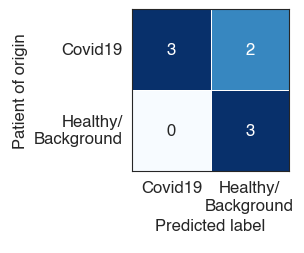


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.029 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.029 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.305 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.305 +/- 0.000 (in 1 folds)
Accuracy: 0.083 +/- 0.000 (in 1 folds)
MCC: -0.592 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.083
MCC: -0.592

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         7
Healthy/Background       0.12      0.20      0.15         5
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.08        12
         macro avg       0.04      0.07      0.05        12
      weighted avg       0.05      0.08      0.06        12



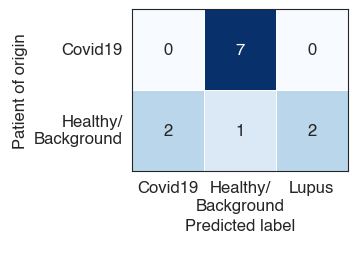


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.067 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.067 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.287 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.287 +/- 0.000 (in 1 folds)
Accuracy: 0.125 +/- 0.000 (in 1 folds)
MCC: -0.537 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.125
MCC: -0.537

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00         5
Healthy/Background       0.17      0.33      0.22         3
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.12         8
         macro avg       0.06      0.11      0.07         8
      weighted avg       0.06      0.12      0.08         8



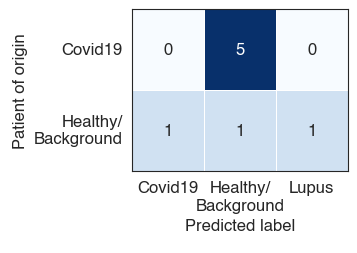


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.067 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.067 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.287 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.287 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.488 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.488

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      1.00      0.83         5
Healthy/Background       1.00      0.33      0.50         3

          accuracy                           0.75         8
         macro avg       0.86      0.67      0.67         8
      weighted avg       0.82      0.75      0.71         8



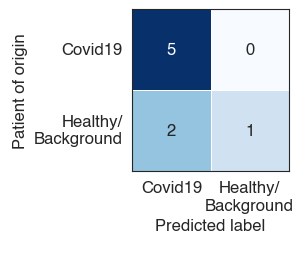


************************************************************



## GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor default

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.-1.external.h5ad -> /srv/scratch/maximz/cache/27a12a200ae71038405d6d88af971b92d069231486cfa1560e84ab74.-1.external.h5ad", "time": "2024-02-22T20:53:44.102568"}


Only considering the two last: ['.external', '.h5ad'].


Only considering the two last: ['.external', '.h5ad'].


{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 234 / 9408 = 2.49%", "time": "2024-02-22T21:40:17.343752"}


{"message": "GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor default: splitting off {'Healthy/Background': 10, 'Covid19': 5} participants per class for decision threshold tuning.", "time": "2024-02-22T21:41:16.645199"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.257893"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.259774"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.261505"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.263380"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.267321"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.269207"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.271469"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.273267"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.278303"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.280226"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.282146"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.284016"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.288123"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.290060"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.291918"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.293809"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.323779"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.325285"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.326873"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.328636"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.332369"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.333964"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.335722"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.337383"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.345433"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.347166"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.348753"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.350318"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.353985"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.355815"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.357631"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.359414"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.387891"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.389331"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.390913"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.392674"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.396432"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.398011"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.399768"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.401299"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.405310"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.407097"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.408847"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.410417"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.413826"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.415597"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.417203"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.418974"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.446912"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.448367"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.449956"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.451547"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.455650"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.457300"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.458841"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.460560"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.464884"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.466488"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.468112"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.469743"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.473272"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.474875"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.476452"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.478066"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.503853"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.505429"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.507026"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.508787"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.513129"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.514664"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.516474"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.518112"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.522851"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.524735"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.526411"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.528226"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.531976"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.533790"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.535611"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.537303"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.566291"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.567638"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.569194"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.570919"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.575057"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.576680"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.578274"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.579866"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.583628"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.585203"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.586982"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.588802"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.592401"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.594242"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.596016"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.597658"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.626477"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.627841"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.629468"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.631217"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.635157"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.636769"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.638353"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.639950"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.644037"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.645736"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.647556"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.649376"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.653230"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.655095"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.656859"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.658717"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.688313"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.689817"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.691405"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.693233"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.697571"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.699244"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.700844"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.702435"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.706850"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.708371"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.709942"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.711555"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.714732"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.716347"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.717998"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.719728"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.747160"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.748598"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.750195"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.751948"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.755882"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.757516"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.759113"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.760710"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.765130"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.766809"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.768598"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.770293"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.774013"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.775756"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.777634"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.779433"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.807424"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.809180"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.810859"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.812483"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.816671"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.818152"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.819741"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.821496"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.826028"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.827690"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.829477"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.831108"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.834759"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.836436"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.838176"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.839972"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.869262"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.870628"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.872166"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.873738"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.877796"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.879408"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.881009"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.882611"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.886528"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.888125"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.889728"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.891339"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.894588"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.896203"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.897989"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.899603"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.926238"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.927590"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.929200"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.930931"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.934878"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.936491"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.938080"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.939785"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.944462"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.945959"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.947579"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.949426"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T21:41:18.953365"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T21:41:18.955252"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T21:41:18.957003"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T21:41:18.958856"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.all_data            0.994 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         0.988 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           0.988 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.975 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.970 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.964 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.964 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.960 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.960 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.955 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.955 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.all_data          0.994 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.988 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.988 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.975 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.970 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.964 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.964 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.960 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.960 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.955 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.955 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.all_data           0.997 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        0.995 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          0.995 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.992 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.989 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.986 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.983 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.983 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.982 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.979 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.979 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.all_data          0.997 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.995 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.995 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.992 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.989 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.986 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.983 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.983 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.982 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.979 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.979 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.all_data          0.679 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.650 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.900 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.696 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.696 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.786 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.6

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.994 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.994 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.997 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.997 +/- 0.000 (in 1 folds)
Accuracy: 0.679 +/- 0.000 (in 1 folds)
MCC: 0.461 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.679
MCC: 0.461

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.06      0.11        17
Healthy/Background       0.97      0.95      0.96        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.68        56
         macro avg       0.66      0.34      0.36        56
      weighted avg       0.98      0.68      0.70        56



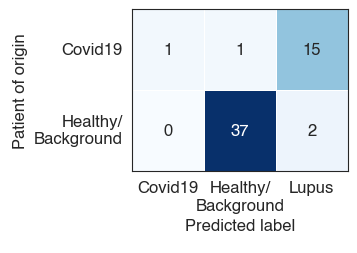


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
Accuracy: 0.650 +/- 0.000 (in 1 folds)
MCC: 0.413 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.650
MCC: 0.413

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.96      0.93      0.95        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.65        40
         macro avg       0.32      0.31      0.32        40
      weighted avg       0.67      0.65      0.66        40



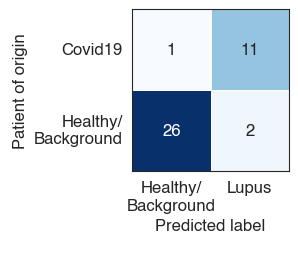


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
Accuracy: 0.900 +/- 0.000 (in 1 folds)
MCC: 0.778 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.900
MCC: 0.778

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.79      0.92      0.85        12
Healthy/Background       0.96      0.89      0.93        28

          accuracy                           0.90        40
         macro avg       0.87      0.90      0.89        40
      weighted avg       0.91      0.90      0.90        40



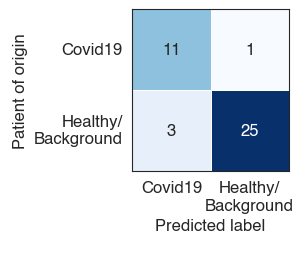


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.986 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.986 +/- 0.000 (in 1 folds)
Accuracy: 0.786 +/- 0.000 (in 1 folds)
MCC: 0.544 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.786
MCC: 0.544

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.88      0.41      0.56        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.90      0.95      0.92        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.79        56
         macro avg       0.44      0.34      0.37        56
      weighted avg       0.89      0.79      0.81        56



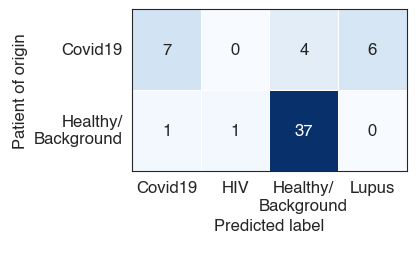


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.955 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.955 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.979 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.979 +/- 0.000 (in 1 folds)
Accuracy: 0.750 +/- 0.000 (in 1 folds)
MCC: 0.476 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.750
MCC: 0.476

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.80      0.33      0.47        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.90      0.93      0.91        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.75        40
         macro avg       0.42      0.32      0.35        40
      weighted avg       0.87      0.75      0.78        40



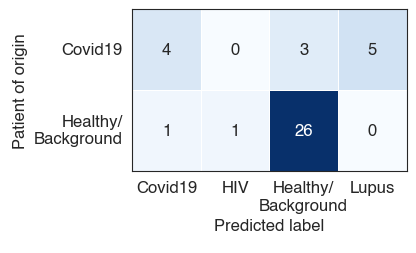


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.955 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.955 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.979 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.979 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.711 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.711

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.77      0.83      0.80        12
Healthy/Background       0.93      0.89      0.91        28

          accuracy                           0.88        40
         macro avg       0.85      0.86      0.85        40
      weighted avg       0.88      0.88      0.88        40



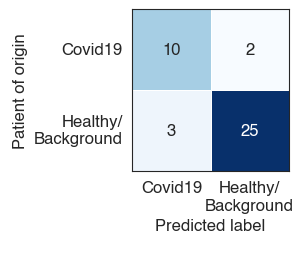


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.992 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.992 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.439 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.439

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.12      0.21        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.93      0.95      0.94        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.70        56
         macro avg       0.48      0.27      0.29        56
      weighted avg       0.95      0.70      0.72        56



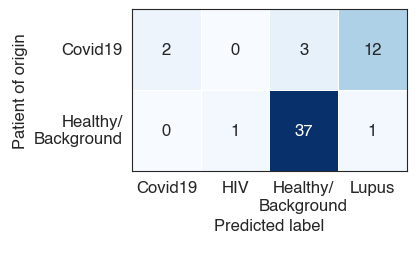


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.964 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.964 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.983 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.983 +/- 0.000 (in 1 folds)
Accuracy: 0.675 +/- 0.000 (in 1 folds)
MCC: 0.410 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.675
MCC: 0.410

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.15        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.93      0.93      0.93        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.68        40
         macro avg       0.48      0.25      0.27        40
      weighted avg       0.95      0.68      0.70        40



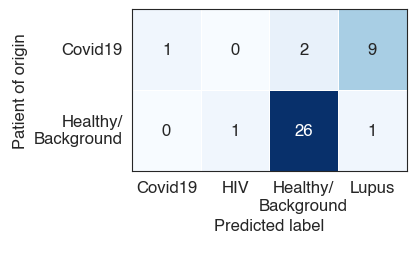


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.964 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.964 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.983 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.983 +/- 0.000 (in 1 folds)
Accuracy: 0.925 +/- 0.000 (in 1 folds)
MCC: 0.823 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.925
MCC: 0.823

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.75      0.86        12
Healthy/Background       0.90      1.00      0.95        28

          accuracy                           0.93        40
         macro avg       0.95      0.88      0.90        40
      weighted avg       0.93      0.93      0.92        40



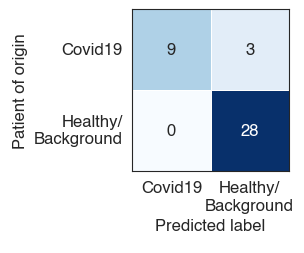


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.975 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.975 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.989 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.989 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.353 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.353

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.85      1.00      0.92        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.70        56
         macro avg       0.28      0.33      0.31        56
      weighted avg       0.59      0.70      0.64        56



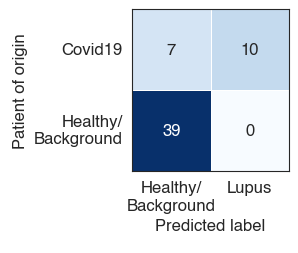


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.960 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.960 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
Accuracy: 0.700 +/- 0.000 (in 1 folds)
MCC: 0.321 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.700
MCC: 0.321

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.82      1.00      0.90        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.70        40
         macro avg       0.27      0.33      0.30        40
      weighted avg       0.58      0.70      0.63        40



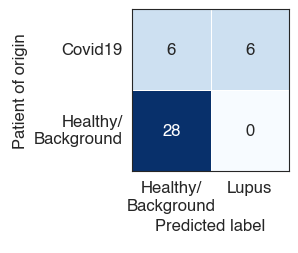


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.960 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.960 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.732 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.732

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.73      0.92      0.81        12
Healthy/Background       0.96      0.86      0.91        28

          accuracy                           0.88        40
         macro avg       0.85      0.89      0.86        40
      weighted avg       0.89      0.88      0.88        40



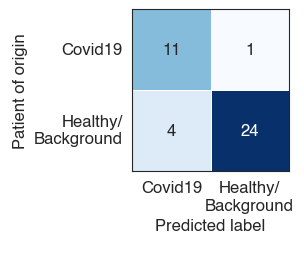


************************************************************



## Metamodel with Models 1 + 3 only for comparison

## GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_sequence_model

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 234 / 9408 = 2.49%", "time": "2024-02-22T22:11:50.362137"}


{"message": "GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_sequence_model: splitting off {'Healthy/Background': 10, 'Covid19': 5} participants per class for decision threshold tuning.", "time": "2024-02-22T22:12:17.842584"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.117360"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.119241"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.121112"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.122909"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.127246"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.128995"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.130676"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.132566"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.137562"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.139449"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.141287"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.143095"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.147182"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.148918"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.150812"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.152710"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.183747"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.185976"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.187889"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.189743"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.194761"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.196400"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.198072"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.199926"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.204678"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.206536"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.208370"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.209998"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.214063"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.215802"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.217655"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.219473"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.248745"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.250326"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.251898"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.253680"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.259712"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.261481"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.263361"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.265210"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.270020"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.271773"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.273525"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.275343"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.279153"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.281018"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.282856"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.284697"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.313983"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.315552"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.317373"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.319160"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.323673"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.325223"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.326865"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.328570"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.332636"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.334452"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.336062"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.337692"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.341146"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.342930"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.344562"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.346172"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.373805"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.375452"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.377086"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.378879"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.382913"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.384703"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.386322"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.387993"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.392068"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.393903"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.395547"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.397361"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.402977"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.404795"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.406455"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.408071"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.433992"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.435561"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.437392"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.439141"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.443163"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.444976"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.446605"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.448223"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.452137"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.453995"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.455679"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.457371"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.461151"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.462989"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.464731"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.466524"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.495140"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.496811"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.498481"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.500262"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.504173"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.505798"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.507452"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.509294"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.513360"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.514949"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.516697"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.518349"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.521681"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.523446"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.525102"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.526886"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.555489"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.557213"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.559040"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.560813"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.564702"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.566521"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.568283"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.569873"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.573808"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.575635"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.577270"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.578941"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.582483"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.584164"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.585901"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.587693"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.614493"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.616013"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.617819"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.619441"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.623538"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.625305"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.627143"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.628944"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.633365"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.635247"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.637100"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.638784"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.642517"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.644213"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.646008"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.647840"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.677765"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.679319"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.681094"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.682839"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.689933"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.691816"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.693706"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.695540"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.700272"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.701940"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.703752"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.705467"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.709315"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.711032"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.712719"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.714423"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.741827"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.743608"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.745291"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.746936"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.751209"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.752933"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.754513"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.756367"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.761219"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.762858"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.764539"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.766239"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.770110"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.771832"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.773546"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.775251"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.802935"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.804679"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.806345"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.808110"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.812152"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.813998"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.815630"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.817461"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.821347"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.823006"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.824595"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.826234"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:12:19.831982"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:12:19.833882"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:12:19.835699"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:12:19.837419"}


ROC-AUC (weighted OvO) per fold  \
rf_multiclass.untuned.all_data       0.980 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.968 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.966 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.966 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.965 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.959 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.949 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.949 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         0.946 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           0.946 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.938 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.938 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
rf_multiclass.untuned.all_data     0.980 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.968 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.966 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.966 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.965 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.959 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.949 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.949 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.946 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.946 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.938 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.938 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
rf_multiclass.untuned.all_data      0.991 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.985 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.985 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.985 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.984 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.981 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.977 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.977 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        0.976 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          0.976 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.971 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.971 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
rf_multiclass.untuned.all_data     0.991 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.985 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.985 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.985 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.984 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.981 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.977 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.977 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.976 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.976 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.971 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.971 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
rf_multiclass.untuned.all_data     0.839 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.875 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.800 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.925 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.893 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.839 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.8

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.965 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.965 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.984 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.984 +/- 0.000 (in 1 folds)
Accuracy: 0.893 +/- 0.000 (in 1 folds)
MCC: 0.777 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.893
MCC: 0.777

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.84      0.94      0.89        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.97      0.87      0.92        39

          accuracy                           0.89        56
         macro avg       0.60      0.60      0.60        56
      weighted avg       0.93      0.89      0.91        56



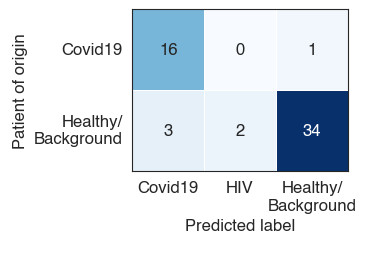


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.946 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.946 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
Accuracy: 0.850 +/- 0.000 (in 1 folds)
MCC: 0.699 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.850
MCC: 0.699

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.79      0.92      0.85        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.96      0.82      0.88        28

          accuracy                           0.85        40
         macro avg       0.58      0.58      0.58        40
      weighted avg       0.91      0.85      0.87        40



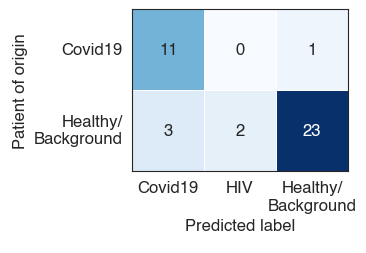


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.946 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.946 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.976 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.976 +/- 0.000 (in 1 folds)
Accuracy: 0.850 +/- 0.000 (in 1 folds)
MCC: 0.643 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.850
MCC: 0.643

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.75      0.75      0.75        12
Healthy/Background       0.89      0.89      0.89        28

          accuracy                           0.85        40
         macro avg       0.82      0.82      0.82        40
      weighted avg       0.85      0.85      0.85        40



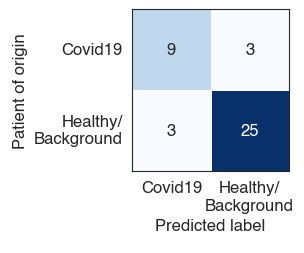


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.959 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.959 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.981 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.981 +/- 0.000 (in 1 folds)
Accuracy: 0.839 +/- 0.000 (in 1 folds)
MCC: 0.681 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.839
MCC: 0.681

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.75      0.88      0.81        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.97      0.82      0.89        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.84        56
         macro avg       0.43      0.43      0.42        56
      weighted avg       0.90      0.84      0.87        56



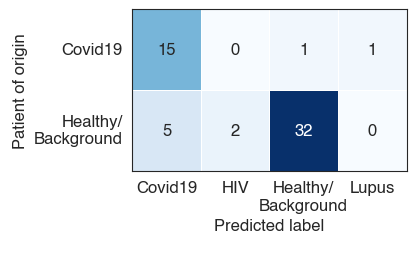


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.938 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.938 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.971 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.971 +/- 0.000 (in 1 folds)
Accuracy: 0.800 +/- 0.000 (in 1 folds)
MCC: 0.612 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.800
MCC: 0.612

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      0.83      0.77        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.96      0.79      0.86        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.80        40
         macro avg       0.42      0.40      0.41        40
      weighted avg       0.88      0.80      0.83        40



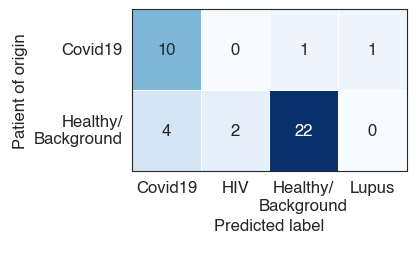


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.938 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.938 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.971 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.971 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.711 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.711

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.77      0.83      0.80        12
Healthy/Background       0.93      0.89      0.91        28

          accuracy                           0.88        40
         macro avg       0.85      0.86      0.85        40
      weighted avg       0.88      0.88      0.88        40



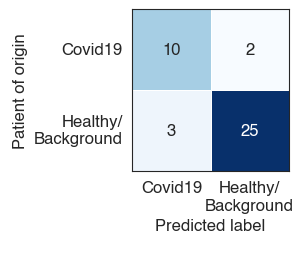


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.968 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.968 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.985 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.985 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.728 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.728

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.88      0.82      0.85        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.95      0.90      0.92        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.88        56
         macro avg       0.46      0.43      0.44        56
      weighted avg       0.92      0.88      0.90        56



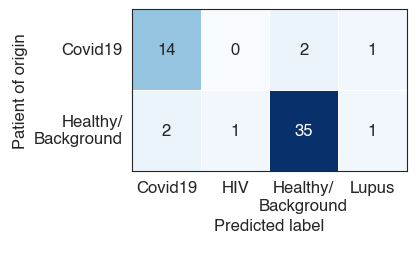


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.949 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.949 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.977 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.977 +/- 0.000 (in 1 folds)
Accuracy: 0.825 +/- 0.000 (in 1 folds)
MCC: 0.628 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.825
MCC: 0.628

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.82      0.75      0.78        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.92      0.86      0.89        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.82        40
         macro avg       0.44      0.40      0.42        40
      weighted avg       0.89      0.82      0.86        40



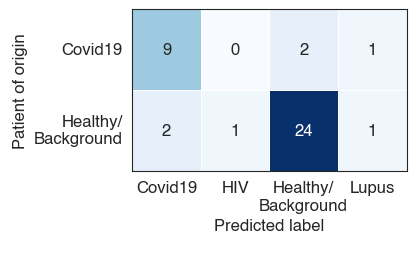


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.949 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.949 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.977 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.977 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.711 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.711

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.77      0.83      0.80        12
Healthy/Background       0.93      0.89      0.91        28

          accuracy                           0.88        40
         macro avg       0.85      0.86      0.85        40
      weighted avg       0.88      0.88      0.88        40



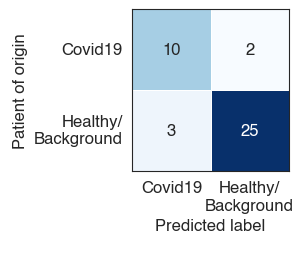


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.980 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.980 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.991 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.991 +/- 0.000 (in 1 folds)
Accuracy: 0.839 +/- 0.000 (in 1 folds)
MCC: 0.647 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.839
MCC: 0.647

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.53      0.69        17
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.90      0.97      0.94        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.84        56
         macro avg       0.48      0.38      0.41        56
      weighted avg       0.93      0.84      0.86        56



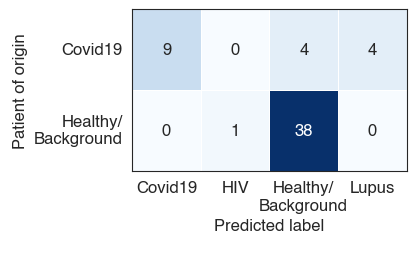


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.966 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.966 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.985 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.985 +/- 0.000 (in 1 folds)
Accuracy: 0.800 +/- 0.000 (in 1 folds)
MCC: 0.553 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.800
MCC: 0.553

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.42      0.59        12
               HIV       0.00      0.00      0.00         0
Healthy/Background       0.87      0.96      0.92        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.80        40
         macro avg       0.47      0.35      0.38        40
      weighted avg       0.91      0.80      0.82        40



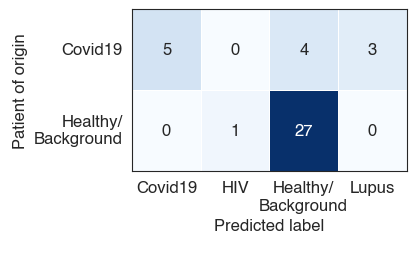


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.966 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.966 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.985 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.985 +/- 0.000 (in 1 folds)
Accuracy: 0.925 +/- 0.000 (in 1 folds)
MCC: 0.819 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.925
MCC: 0.819

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.91      0.83      0.87        12
Healthy/Background       0.93      0.96      0.95        28

          accuracy                           0.93        40
         macro avg       0.92      0.90      0.91        40
      weighted avg       0.92      0.93      0.92        40



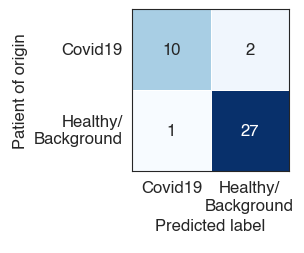


************************************************************



## Metamodel with Models 1 + 2 only for comparison

## GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_convergent_cluster_model

{"message": "GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_repertoire_stats_convergent_cluster_model: splitting off {'Healthy/Background': 10, 'Covid19': 5} participants per class for decision threshold tuning.", "time": "2024-02-22T22:21:15.589583"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.390223"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.392166"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.393897"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.395551"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.402321"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.403924"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.405856"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.407729"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.412770"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.414572"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.416589"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.418357"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.422338"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.424260"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.425953"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.427842"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.458665"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.460041"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.461702"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.463313"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.467255"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.468959"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.470725"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.472334"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.476159"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.477823"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.479434"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.481139"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.484814"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.486684"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.488562"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.490237"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.520154"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.521584"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.523228"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.524852"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.528829"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.532969"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.534843"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.536698"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.541063"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.542917"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.544848"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.546566"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.550549"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.552537"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.554600"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.556624"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.587688"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.589086"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.590719"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.592442"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.596848"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.598595"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.600342"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.602000"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.606388"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.608272"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.610024"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.611868"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.615671"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.617596"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.619396"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.621239"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.649404"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.650786"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.652421"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.654041"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.658039"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.659718"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.661427"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.663059"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.667373"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.669095"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.670761"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.672451"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.676270"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.678061"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.679814"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.681592"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.711775"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.713245"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.714896"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.716530"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.720751"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.722310"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.723940"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.725800"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.730598"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.732266"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.734031"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.735903"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.739815"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.741757"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.743606"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.745631"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.775309"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.776780"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.778453"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.780078"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.784519"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.786228"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.788121"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.789981"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.794762"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.796576"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.798362"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.800265"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.804126"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.805929"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.807682"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.809542"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.839797"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.841543"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.843181"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.844768"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.848979"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.850651"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.852455"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.854071"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.858538"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.860214"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.861867"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.863522"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.867112"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.868765"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.870471"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.872248"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.899804"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.901250"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.902830"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.904594"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.908742"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.910556"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.912380"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.914017"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.918472"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.920214"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.921833"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.923634"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.927397"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.929130"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.930802"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.932548"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.961377"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.962771"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.965986"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.967781"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.971803"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.973465"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.975011"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.976756"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.981421"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.982938"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.984533"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.986142"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:17.990243"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:17.992011"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:17.993767"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:17.995514"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.025004"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.026372"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.027912"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.029675"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.033557"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.035142"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.036913"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.038511"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.042458"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.044041"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.045652"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.047301"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.051036"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.052844"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.054481"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.056308"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.085178"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.086549"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.088145"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.089907"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.093828"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.095455"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.097092"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.098921"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.103637"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.105536"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.107291"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.109121"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:21:18.115061"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:21:18.117142"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:21:18.119012"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:21:18.120809"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.all_data            0.982 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.978 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.973 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         0.970 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           0.970 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.970 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.970 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.969 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.969 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.961 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.961 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.all_data          0.982 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.982 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.978 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.973 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.970 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.970 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.970 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.970 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.969 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.969 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.961 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.961 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.all_data           0.992 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.992 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.991 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.988 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        0.987 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          0.987 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.987 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.987 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.987 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.987 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.983 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.983 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.all_data          0.992 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.992 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.991 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.988 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.987 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.987 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.987 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.987 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.987 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.987 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.983 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.983 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.all_data          0.661 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.661 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.696 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.661 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.650 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.900 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.6

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.992 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.992 +/- 0.000 (in 1 folds)
Accuracy: 0.661 +/- 0.000 (in 1 folds)
MCC: 0.416 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.661
MCC: 0.416

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.95      0.95      0.95        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.66        56
         macro avg       0.32      0.32      0.32        56
      weighted avg       0.66      0.66      0.66        56



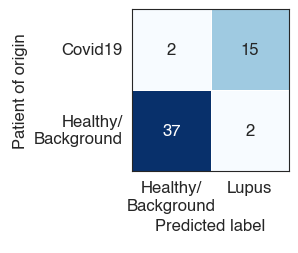


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.650 +/- 0.000 (in 1 folds)
MCC: 0.381 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.650
MCC: 0.381

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.93      0.93      0.93        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.65        40
         macro avg       0.31      0.31      0.31        40
      weighted avg       0.65      0.65      0.65        40



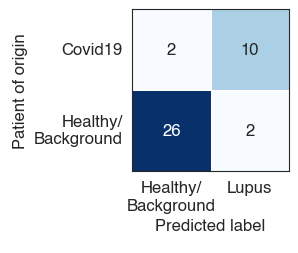


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.900 +/- 0.000 (in 1 folds)
MCC: 0.762 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.900
MCC: 0.762

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      0.83      0.83        12
Healthy/Background       0.93      0.93      0.93        28

          accuracy                           0.90        40
         macro avg       0.88      0.88      0.88        40
      weighted avg       0.90      0.90      0.90        40



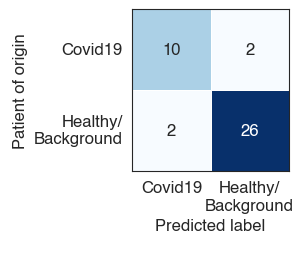


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.973 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.973 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
Accuracy: 0.661 +/- 0.000 (in 1 folds)
MCC: 0.416 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.661
MCC: 0.416

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.95      0.95      0.95        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.66        56
         macro avg       0.32      0.32      0.32        56
      weighted avg       0.66      0.66      0.66        56



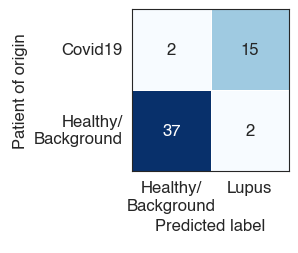


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.961 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.961 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.983 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.983 +/- 0.000 (in 1 folds)
Accuracy: 0.650 +/- 0.000 (in 1 folds)
MCC: 0.381 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.650
MCC: 0.381

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.93      0.93      0.93        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.65        40
         macro avg       0.31      0.31      0.31        40
      weighted avg       0.65      0.65      0.65        40



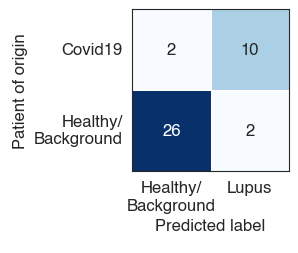


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.961 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.961 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.983 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.983 +/- 0.000 (in 1 folds)
Accuracy: 0.850 +/- 0.000 (in 1 folds)
MCC: 0.663 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.850
MCC: 0.663

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.71      0.83      0.77        12
Healthy/Background       0.92      0.86      0.89        28

          accuracy                           0.85        40
         macro avg       0.82      0.85      0.83        40
      weighted avg       0.86      0.85      0.85        40



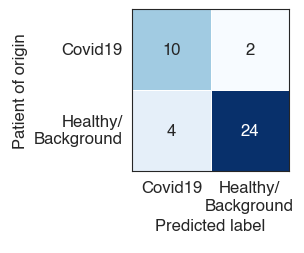


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.992 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.992 +/- 0.000 (in 1 folds)
Accuracy: 0.661 +/- 0.000 (in 1 folds)
MCC: 0.416 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.661
MCC: 0.416

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.95      0.95      0.95        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.66        56
         macro avg       0.32      0.32      0.32        56
      weighted avg       0.66      0.66      0.66        56



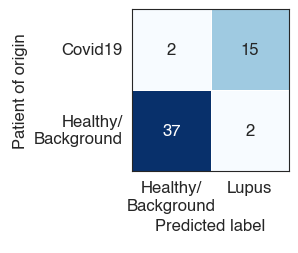


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.650 +/- 0.000 (in 1 folds)
MCC: 0.381 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.650
MCC: 0.381

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.93      0.93      0.93        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.65        40
         macro avg       0.31      0.31      0.31        40
      weighted avg       0.65      0.65      0.65        40



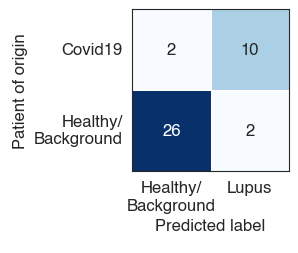


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.900 +/- 0.000 (in 1 folds)
MCC: 0.762 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.900
MCC: 0.762

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      0.83      0.83        12
Healthy/Background       0.93      0.93      0.93        28

          accuracy                           0.90        40
         macro avg       0.88      0.88      0.88        40
      weighted avg       0.90      0.90      0.90        40



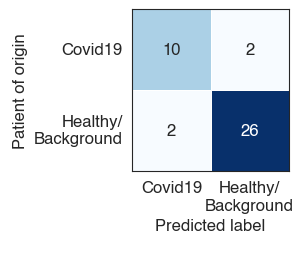


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.978 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.978 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.991 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.991 +/- 0.000 (in 1 folds)
Accuracy: 0.696 +/- 0.000 (in 1 folds)
MCC: 0.331 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.696
MCC: 0.331

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.83      1.00      0.91        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.70        56
         macro avg       0.28      0.33      0.30        56
      weighted avg       0.58      0.70      0.63        56



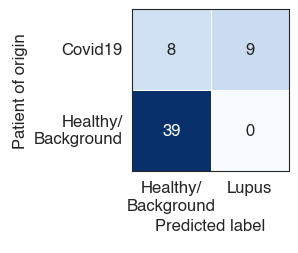


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.969 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.969 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.700 +/- 0.000 (in 1 folds)
MCC: 0.289 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.700
MCC: 0.289

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.80      1.00      0.89        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.70        40
         macro avg       0.27      0.33      0.30        40
      weighted avg       0.56      0.70      0.62        40



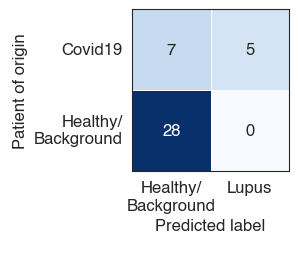


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.969 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.969 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.987 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.987 +/- 0.000 (in 1 folds)
Accuracy: 0.900 +/- 0.000 (in 1 folds)
MCC: 0.756 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.900
MCC: 0.756

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.90      0.75      0.82        12
Healthy/Background       0.90      0.96      0.93        28

          accuracy                           0.90        40
         macro avg       0.90      0.86      0.87        40
      weighted avg       0.90      0.90      0.90        40



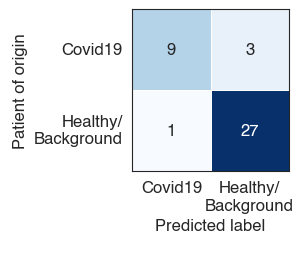


************************************************************



## Metamodel with Models 2 + 3 only for comparison

## GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_convergent_cluster_model_sequence_model

{"message": "Number of VJGeneSpecificSequenceModelRollupClassifier featurization matrix N/As due to specimens not having any sequences with particular V/J gene pairs: 234 / 9408 = 2.49%", "time": "2024-02-22T22:54:21.727423"}


{"message": "GeneLocus.TCR, TargetObsColumnEnum.disease, metamodel flavor subset_of_submodels_convergent_cluster_model_sequence_model: splitting off {'Healthy/Background': 10, 'Covid19': 5} participants per class for decision threshold tuning.", "time": "2024-02-22T22:54:49.297776"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.517055"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.518913"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.520783"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.522429"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.526845"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.528341"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.529968"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.531578"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.536035"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.537703"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.539492"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.541291"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.544849"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.546702"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.548585"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.550452"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.579446"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.580912"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.582707"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.584360"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.588334"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.590000"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.591613"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.593215"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.597623"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.599263"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.601086"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.602884"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.606727"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.608452"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.610256"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.612042"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.641112"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.642465"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.644096"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.645736"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.649897"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.651742"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.653566"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.655390"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.659973"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.661700"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.663499"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.665320"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.669096"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.670946"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.672745"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.674356"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.701707"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.703350"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.705016"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.706643"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.711063"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.712742"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.714567"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.716364"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.720986"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.722703"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.724389"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.726028"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.729849"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.731568"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.733267"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.734934"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.762282"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.763680"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.765507"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.767125"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.771190"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.773065"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.774873"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.778489"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.782843"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.784567"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.786211"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.787851"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.791610"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.793516"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.795216"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.796906"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.824975"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.826512"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.828167"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.829915"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.833872"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.835673"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.837315"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.838939"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.843467"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.845183"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.846849"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.848522"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.852040"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.853827"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.855665"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.857517"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.886626"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.887984"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.889626"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.891237"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.895200"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.896856"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.898477"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.900068"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.904891"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.906608"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.908292"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.909937"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.913651"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.915494"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.917241"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.919021"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.946750"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.948098"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.949737"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.951336"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.955232"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.956914"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.958529"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.960124"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.964503"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.966371"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.968088"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.969879"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:51.973530"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:51.975372"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:51.977118"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:51.979014"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.008181"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.009557"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.011174"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.012969"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.017078"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.018802"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.020618"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.022236"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.027127"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.028731"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.030378"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.032058"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.035674"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.037452"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.039250"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.040916"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.067902"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.069720"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.071384"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.073031"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.079702"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.081449"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.083245"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.085076"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.089665"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.091345"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.093046"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.094704"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.098400"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.100269"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.101935"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.103579"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.131383"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.132836"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.134487"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.136098"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.140392"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.141893"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.143506"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.145111"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.149554"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.151054"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.152710"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.154305"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.158125"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.159832"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.161516"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.163216"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.192110"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.193558"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.195208"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.196827"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.200746"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.202401"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.204055"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.205913"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.210736"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.212554"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.214244"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.215988"}


{"message": "Removing class absent from y_true: Influenza", "time": "2024-02-22T22:54:52.219906"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T22:54:52.221807"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T22:54:52.223576"}


{"message": "Removing class absent from y_true: T1D", "time": "2024-02-22T22:54:52.225416"}


ROC-AUC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset         0.991 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           0.991 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.988 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.988 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.982 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.977 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.940 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.932 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.932 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset    0.844 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.844 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.836 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       0.991 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.991 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.988 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.988 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.982 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.977 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.940 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.932 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.932 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.844 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.844 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.836 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
ridge_cv.untuned.test_subset        0.996 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          0.996 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.995 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.995 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.993 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.991 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.975 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.970 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.970 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset   0.923 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.923 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.917 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
ridge_cv.untuned.test_subset       0.996 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.996 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.995 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.995 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.993 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.991 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.975 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.970 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.970 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.test_subset  0.923 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.923 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.917 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
ridge_cv.untuned.test_subset       0.450 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.850 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.550 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.875 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.518 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.446 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.6

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.977 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.977 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.991 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.991 +/- 0.000 (in 1 folds)
Accuracy: 0.446 +/- 0.000 (in 1 folds)
MCC: 0.291 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.446
MCC: 0.291

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       1.00      0.64      0.78        39
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.45        56
         macro avg       0.25      0.16      0.20        56
      weighted avg       0.70      0.45      0.54        56



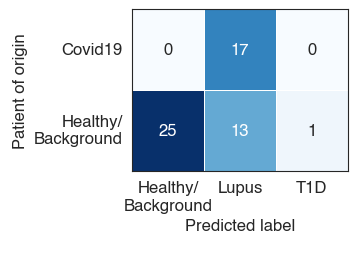


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.991 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.991 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.996 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.996 +/- 0.000 (in 1 folds)
Accuracy: 0.450 +/- 0.000 (in 1 folds)
MCC: 0.296 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.450
MCC: 0.296

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       1.00      0.64      0.78        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.45        40
         macro avg       0.33      0.21      0.26        40
      weighted avg       0.70      0.45      0.55        40



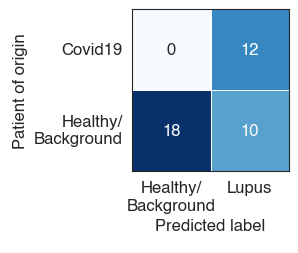


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.991 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.991 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.996 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.996 +/- 0.000 (in 1 folds)
Accuracy: 0.850 +/- 0.000 (in 1 folds)
MCC: 0.643 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.850
MCC: 0.643

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.75      0.75      0.75        12
Healthy/Background       0.89      0.89      0.89        28

          accuracy                           0.85        40
         macro avg       0.82      0.82      0.82        40
      weighted avg       0.85      0.85      0.85        40



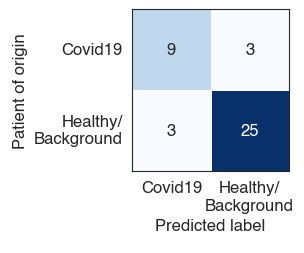


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.982 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.982 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.993 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.993 +/- 0.000 (in 1 folds)
Accuracy: 0.518 +/- 0.000 (in 1 folds)
MCC: 0.346 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.518
MCC: 0.346

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.06      0.11        17
Healthy/Background       1.00      0.72      0.84        39
             Lupus       0.00      0.00      0.00         0
               T1D       0.00      0.00      0.00         0

          accuracy                           0.52        56
         macro avg       0.50      0.19      0.24        56
      weighted avg       1.00      0.52      0.62        56



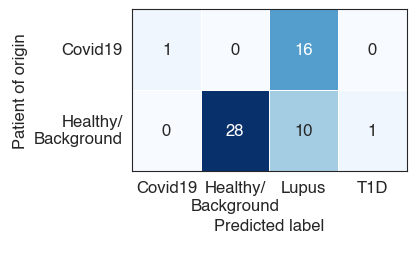


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
Accuracy: 0.550 +/- 0.000 (in 1 folds)
MCC: 0.374 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.550
MCC: 0.374

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.15        12
Healthy/Background       1.00      0.75      0.86        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.55        40
         macro avg       0.67      0.28      0.34        40
      weighted avg       1.00      0.55      0.65        40



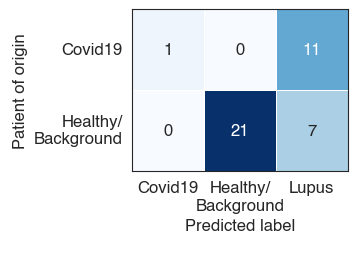


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.988 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.988 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.995 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.995 +/- 0.000 (in 1 folds)
Accuracy: 0.875 +/- 0.000 (in 1 folds)
MCC: 0.696 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.875
MCC: 0.696

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.82      0.75      0.78        12
Healthy/Background       0.90      0.93      0.91        28

          accuracy                           0.88        40
         macro avg       0.86      0.84      0.85        40
      weighted avg       0.87      0.88      0.87        40



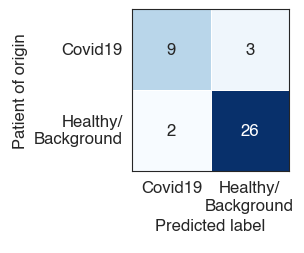


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.940 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.940 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.975 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.975 +/- 0.000 (in 1 folds)
Accuracy: 0.661 +/- 0.000 (in 1 folds)
MCC: 0.426 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.661
MCC: 0.426

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.12      0.21        17
Healthy/Background       0.95      0.90      0.92        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.66        56
         macro avg       0.65      0.34      0.38        56
      weighted avg       0.96      0.66      0.71        56



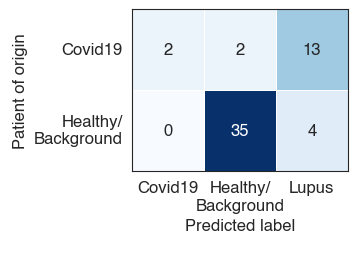


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.932 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.932 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
Accuracy: 0.625 +/- 0.000 (in 1 folds)
MCC: 0.398 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.625
MCC: 0.398

Global classification report:
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.15        12
Healthy/Background       0.96      0.86      0.91        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.62        40
         macro avg       0.65      0.31      0.35        40
      weighted avg       0.97      0.62      0.68        40



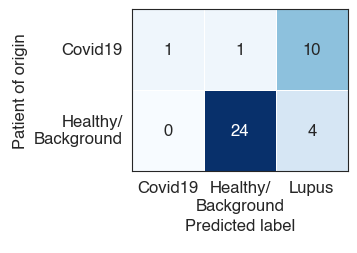


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.932 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.932 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.970 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.970 +/- 0.000 (in 1 folds)
Accuracy: 0.775 +/- 0.000 (in 1 folds)
MCC: 0.507 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.775
MCC: 0.507

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.60      0.75      0.67        12
Healthy/Background       0.88      0.79      0.83        28

          accuracy                           0.78        40
         macro avg       0.74      0.77      0.75        40
      weighted avg       0.80      0.78      0.78        40



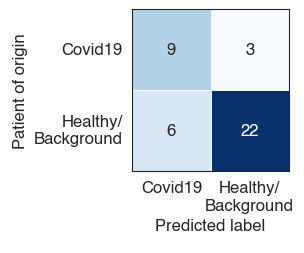


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.836 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.836 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.917 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.917 +/- 0.000 (in 1 folds)
Accuracy: 0.679 +/- 0.000 (in 1 folds)
MCC: 0.228 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.679
MCC: 0.228

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.78      0.97      0.86        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.68        56
         macro avg       0.26      0.32      0.29        56
      weighted avg       0.54      0.68      0.60        56



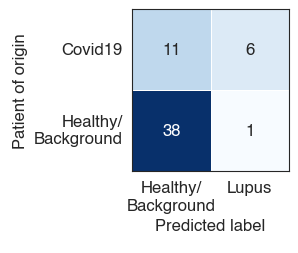


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.844 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.844 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.923 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.923 +/- 0.000 (in 1 folds)
Accuracy: 0.675 +/- 0.000 (in 1 folds)
MCC: 0.206 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.675
MCC: 0.206

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.77      0.96      0.86        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.68        40
         macro avg       0.26      0.32      0.29        40
      weighted avg       0.54      0.68      0.60        40



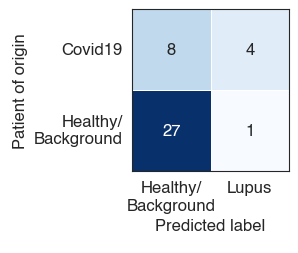


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.844 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.844 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.923 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.923 +/- 0.000 (in 1 folds)
Accuracy: 0.800 +/- 0.000 (in 1 folds)
MCC: 0.489 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.800
MCC: 0.489

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.83      0.42      0.56        12
Healthy/Background       0.79      0.96      0.87        28

          accuracy                           0.80        40
         macro avg       0.81      0.69      0.71        40
      weighted avg       0.81      0.80      0.78        40



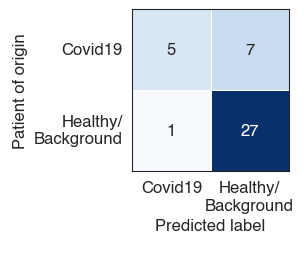


************************************************************



## Demographics-only metamodel for comparison

## GeneLocus.TCR, TargetObsColumnEnum.disease_all_demographics_present, metamodel flavor demographics_only

{"message": "Adding metadata featurizer demographics for TargetObsColumnEnum.disease_all_demographics_present", "time": "2024-02-22T23:00:50.084172"}


{"message": "GeneLocus.TCR, TargetObsColumnEnum.disease_all_demographics_present, metamodel flavor demographics_only: splitting off {'Healthy/Background': 10, 'Covid19': 5} participants per class for decision threshold tuning.", "time": "2024-02-22T23:00:55.479557"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.446818"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.448828"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.454340"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.456094"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.460758"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.462450"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.466375"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.468282"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.499300"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.501073"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.505862"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.507568"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.512291"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.514071"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.518079"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.519862"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.549274"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.550708"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.555414"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.557117"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.561698"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.563458"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.567290"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.569202"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.602193"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.603922"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.609235"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.610952"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.615642"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.617606"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.621550"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.623501"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.651217"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.652986"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.657533"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.659279"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.664085"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.665919"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.669779"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.671741"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.701549"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.703109"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.708068"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.710002"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.714516"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.716433"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.720176"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.722193"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.751215"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.752727"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.757274"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.758997"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.763777"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.766061"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.770038"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.771787"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.807512"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.809598"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.814477"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.816455"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.821225"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.823476"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.827315"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.829295"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.857516"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.859386"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.864087"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.865948"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.870551"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.872328"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.875955"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.877876"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.911547"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.913172"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.918632"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.921001"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.926520"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.930099"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.934693"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.936601"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.971493"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.973044"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.977837"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.979520"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.984497"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.986184"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:57.990247"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:57.992046"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:58.024683"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:58.026156"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:58.030743"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:58.032474"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:58.036976"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:58.038903"}


{"message": "Removing class absent from y_true: HIV", "time": "2024-02-22T23:00:58.042781"}


{"message": "Removing class absent from y_true: Lupus", "time": "2024-02-22T23:00:58.044730"}


ROC-AUC (weighted OvO) per fold  \
rf_multiclass.untuned.test_subset    0.609 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset      0.609 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data       0.594 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data       0.518 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data            0.477 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data            0.476 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset    0.463 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset      0.463 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset         0.457 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset           0.457 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset         0.454 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset           0.454 +/- 0.000 (in 1 folds)   

                                   ROC-AUC (macro OvO) per fold  \
rf_multiclass.untuned.test_subset  0.609 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.609 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.594 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.518 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.477 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.476 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.463 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.463 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.457 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.457 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.454 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.454 +/- 0.000 (in 1 folds)   

                                  au-PRC (weighted OvO) per fold  \
rf_multiclass.untuned.test_subset   0.816 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset     0.816 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data      0.791 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data      0.789 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data           0.730 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data           0.737 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset   0.755 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset     0.755 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset        0.720 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset          0.720 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset        0.721 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset          0.721 +/- 0.000 (in 1 folds)   

                                    au-PRC (macro OvO) per fold  \
rf_multiclass.untuned.test_subset  0.816 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.816 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.791 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.789 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.730 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.737 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.755 +/- 0.000 (in 1 folds)   
elasticnet_cv.tuned.test_subset    0.755 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.test_subset       0.720 +/- 0.000 (in 1 folds)   
ridge_cv.tuned.test_subset         0.720 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.test_subset       0.721 +/- 0.000 (in 1 folds)   
lasso_cv.tuned.test_subset         0.721 +/- 0.000 (in 1 folds)   

                                              Accuracy per fold  \
rf_multiclass.untuned.test_subset  0.500 +/- 0.000 (in 1 folds)   
rf_multiclass.tuned.test_subset    0.675 +/- 0.000 (in 1 folds)   
rf_multiclass.untuned.all_data     0.500 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.all_data     0.518 +/- 0.000 (in 1 folds)   
ridge_cv.untuned.all_data          0.536 +/- 0.000 (in 1 folds)   
lasso_cv.untuned.all_data          0.500 +/- 0.000 (in 1 folds)   
elasticnet_cv.untuned.test_subset  0.5

ridge_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.477 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.477 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.730 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.730 +/- 0.000 (in 1 folds)
Accuracy: 0.536 +/- 0.000 (in 1 folds)
MCC: -0.020 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.536
MCC: -0.020

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.71      0.77      0.74        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.54        56
         macro avg       0.24      0.26      0.25        56
      weighted avg       0.50      0.54      0.52        56



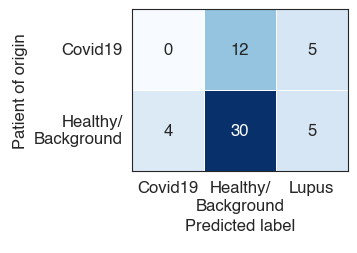


************************************************************

ridge_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.457 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.457 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.720 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.720 +/- 0.000 (in 1 folds)
Accuracy: 0.525 +/- 0.000 (in 1 folds)
MCC: 0.006 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.525
MCC: 0.006

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.72      0.75      0.74        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.53        40
         macro avg       0.24      0.25      0.25        40
      weighted avg       0.51      0.53      0.52        40



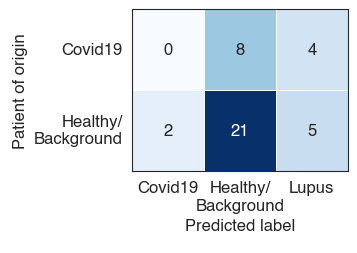


************************************************************

ridge_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.457 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.457 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.720 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.720 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: 0.044 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: 0.044

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.32      0.58      0.41        12
Healthy/Background       0.72      0.46      0.57        28

          accuracy                           0.50        40
         macro avg       0.52      0.52      0.49        40
      weighted avg       0.60      0.50      0.52        40



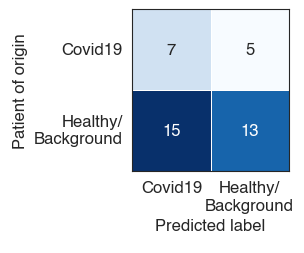


************************************************************

elasticnet_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.518 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.518 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.789 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.789 +/- 0.000 (in 1 folds)
Accuracy: 0.518 +/- 0.000 (in 1 folds)
MCC: -0.045 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.518
MCC: -0.045

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.71      0.74      0.72        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.52        56
         macro avg       0.24      0.25      0.24        56
      weighted avg       0.49      0.52      0.50        56



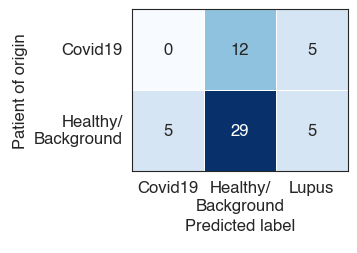


************************************************************

elasticnet_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.463 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.463 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.755 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.755 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: -0.029 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: -0.029

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.71      0.71      0.71        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        40
         macro avg       0.24      0.24      0.24        40
      weighted avg       0.50      0.50      0.50        40



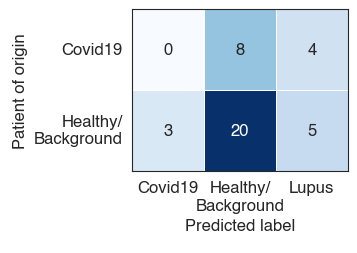


************************************************************

elasticnet_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.463 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.463 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.755 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.755 +/- 0.000 (in 1 folds)
Accuracy: 0.550 +/- 0.000 (in 1 folds)
MCC: 0.109 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.550
MCC: 0.109

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.35      0.58      0.44        12
Healthy/Background       0.75      0.54      0.63        28

          accuracy                           0.55        40
         macro avg       0.55      0.56      0.53        40
      weighted avg       0.63      0.55      0.57        40



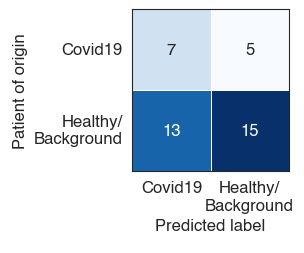


************************************************************

lasso_cv.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.476 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.476 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.737 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.737 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: -0.057 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: -0.057

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        17
Healthy/Background       0.70      0.72      0.71        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        56
         macro avg       0.23      0.24      0.24        56
      weighted avg       0.49      0.50      0.49        56



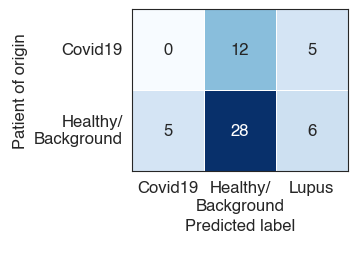


************************************************************

lasso_cv.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.454 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.454 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.721 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.721 +/- 0.000 (in 1 folds)
Accuracy: 0.475 +/- 0.000 (in 1 folds)
MCC: -0.045 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.475
MCC: -0.045

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        12
Healthy/Background       0.70      0.68      0.69        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.48        40
         macro avg       0.23      0.23      0.23        40
      weighted avg       0.49      0.47      0.48        40



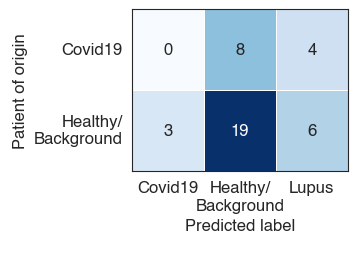


************************************************************

lasso_cv.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.454 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.454 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.721 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.721 +/- 0.000 (in 1 folds)
Accuracy: 0.550 +/- 0.000 (in 1 folds)
MCC: 0.109 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.550
MCC: 0.109

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.35      0.58      0.44        12
Healthy/Background       0.75      0.54      0.63        28

          accuracy                           0.55        40
         macro avg       0.55      0.56      0.53        40
      weighted avg       0.63      0.55      0.57        40



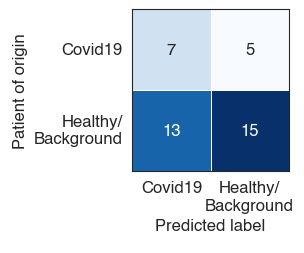


************************************************************

rf_multiclass.untuned.all_data
Per-fold scores:
ROC-AUC (weighted OvO): 0.594 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.594 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.791 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.791 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: 0.082 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: 0.082

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.43      0.18      0.25        17
Healthy/Background       0.74      0.64      0.68        39
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        56
         macro avg       0.39      0.27      0.31        56
      weighted avg       0.64      0.50      0.55        56



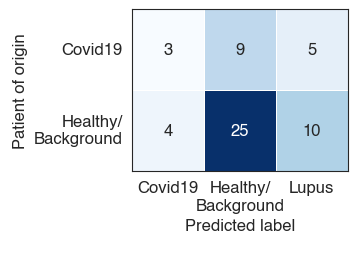


************************************************************

rf_multiclass.untuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.609 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.609 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.816 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.816 +/- 0.000 (in 1 folds)
Accuracy: 0.500 +/- 0.000 (in 1 folds)
MCC: 0.089 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.500
MCC: 0.089

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.40      0.17      0.24        12
Healthy/Background       0.75      0.64      0.69        28
             Lupus       0.00      0.00      0.00         0

          accuracy                           0.50        40
         macro avg       0.38      0.27      0.31        40
      weighted avg       0.65      0.50      0.56        40



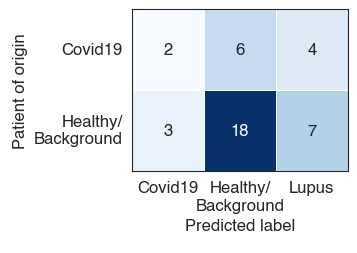


************************************************************

rf_multiclass.tuned.test_subset
Per-fold scores:
ROC-AUC (weighted OvO): 0.609 +/- 0.000 (in 1 folds)
ROC-AUC (macro OvO): 0.609 +/- 0.000 (in 1 folds)
au-PRC (weighted OvO): 0.816 +/- 0.000 (in 1 folds)
au-PRC (macro OvO): 0.816 +/- 0.000 (in 1 folds)
Accuracy: 0.675 +/- 0.000 (in 1 folds)
MCC: 0.021 +/- 0.000 (in 1 folds)

Global scores:
Accuracy: 0.675
MCC: 0.021

Global classification report:
                    precision    recall  f1-score   support

           Covid19       0.33      0.08      0.13        12
Healthy/Background       0.70      0.93      0.80        28

          accuracy                           0.68        40
         macro avg       0.52      0.51      0.47        40
      weighted avg       0.59      0.68      0.60        40



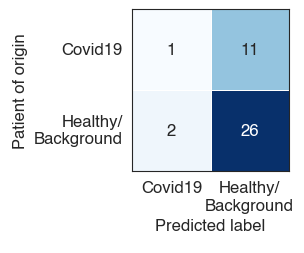


************************************************************



In [8]:
results_by_gene_locus = {}
featurized_by_gene_locus = {}

for gene_locus in gene_loci:
    # run on single locus

    # default flavor:
    results, featurized = run(
        gene_locus=gene_locus,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "default"
        / gene_locus.name,
    )
    if results is not None:
        results_by_gene_locus[gene_locus] = results
        featurized_by_gene_locus[gene_locus] = featurized

    ## models 1+3 only:
    display(Markdown("## Metamodel with Models 1 + 3 only for comparison"))
    run(
        gene_locus=gene_locus,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "subset_of_submodels_repertoire_stats_sequence_model"
        / gene_locus.name,
        metamodel_flavor="subset_of_submodels_repertoire_stats_sequence_model",
    )

    ## models 1+2 only:
    display(Markdown("## Metamodel with Models 1 + 2 only for comparison"))
    run(
        gene_locus=gene_locus,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "subset_of_submodels_repertoire_stats_convergent_cluster_model"
        / gene_locus.name,
        metamodel_flavor="subset_of_submodels_repertoire_stats_convergent_cluster_model",
    )

    ## models 2+3 only:
    display(Markdown("## Metamodel with Models 2 + 3 only for comparison"))
    run(
        gene_locus=gene_locus,
        classification_target=evaluation_target,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "subset_of_submodels_convergent_cluster_model_sequence_model"
        / gene_locus.name,
        metamodel_flavor="subset_of_submodels_convergent_cluster_model_sequence_model",
    )

    ## demographics only:
    display(Markdown("## Demographics-only metamodel for comparison"))
    run(
        gene_locus=gene_locus,
        classification_target=evaluation_target_with_demographics,
        output_dir=config.paths.external_cohort_evaluation_output_dir
        / "demographics_only"
        / gene_locus.name,
        metamodel_flavor="demographics_only",
    )

    io.clear_cached_fold_embeddings()

### GeneLocus.BCR

BCR:repertoire_stats:Covid19  BCR:repertoire_stats:HIV  \
specimen_label                                                            
Kim_C_d15                            0.986367                  0.000390   
Kim_E_d23                            0.918274                  0.031713   
Kim_F_d14                            0.904597                  0.006100   
Briney_326650_1                      0.000087                  0.003862   
Briney_326780_1                      0.000137                  0.254562   
Briney_326737_1                      0.000013                  0.617078   
Briney_D103_1                        0.000453                  0.000169   
Kim_B_d19                            0.822403                  0.011479   
Briney_326797_1                      0.000408                  0.003361   
Kim_A_d17                            0.978285                  0.009756   
Kim_D_d28                            0.078375                  0.007363   
Briney_327059_1                      0.000436                  0.067644   
Kim_G_d22                            0.425181                  0.022151   

                 BCR:repertoire_stats:Healthy/Background  \
specimen_label                                             
Kim_C_d15                                       0.000403   
Kim_E_d23                                       0.000009   
Kim_F_d14                                       0.001301   
Briney_326650_1                                 0.013794   
Briney_326780_1                                 0.530025   
Briney_326737_1                                 0.082491   
Briney_D103_1                                   0.005533   
Kim_B_d19                                       0.006862   
Briney_326797_1                                 0.009535   
Kim_A_d17                                       0.000002   
Kim_D_d28                                       0.024867   
Briney_327059_1                                 0.053990   
Kim_G_d22                                       0.004820   

                 BCR:repertoire_stats:Influenza  BCR:repertoire_stats:Lupus  \
specimen_label                                                                
Kim_C_d15                          4.713920e-04                    0.011428   
Kim_E_d23                          1.627032e-03                    0.039935   
Kim_F_d14                          1.121146e-03                    0.051591   
Briney_326650_1                    1.020907e-08                    0.348491   
Briney_326780_1                    9.357388e-06                    0.013305   
Briney_326737_1                    9.814964e-09                    0.164850   
Briney_D103_1                      1.060988e-08                    0.178377   
Kim_B_d19                          2.141096e-02                    0.091024   
Briney_326797_1                    2.087122e-06                    0.021304   
Kim_A_d17                          2.307431e-05                    0.011920   
Kim_D_d28                          3.053274e-01                    0.110791   
Briney_327059_1                    8.803305e-08                    0.052689   
Kim_G_d22                          2.830286e-01                    0.252206   

                 BCR:repertoire_stats:T1D  \
specimen_label                              
Kim_C_d15                        0.000940   
Kim_E_d23                        0.008441   
Kim_F_d14                        0.035289   
Briney_326650_1                  0.633766   
Briney_326780_1                  0.201961   
Briney_326737_1                  0.135568   
Briney_D103_1                    0.815467   
Kim_B_d19                        0.046821   
Briney_326797_1                  0.965390   
Kim_A_d17                        0.000015   
Kim_D_d28                        0.473278   
Briney_327059_1                  0.825241   
Kim_G_d22                        0.012613   

                 BCR:convergent_cluster_model:Covid19  \
specimen_label                                          
Kim_C_d15     

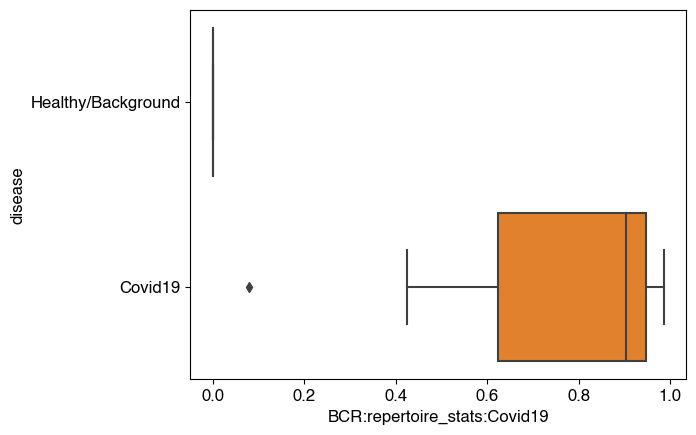

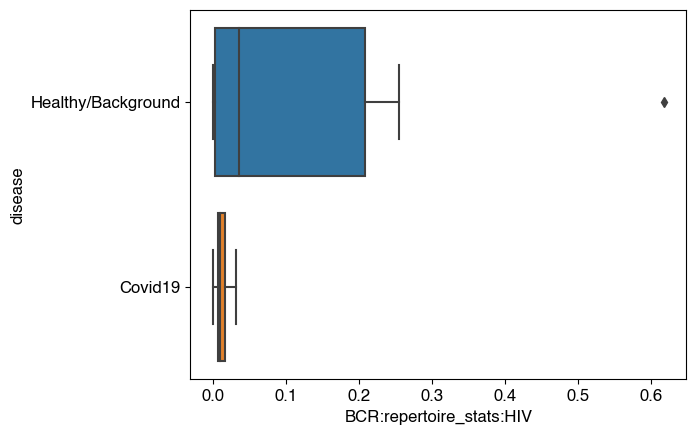

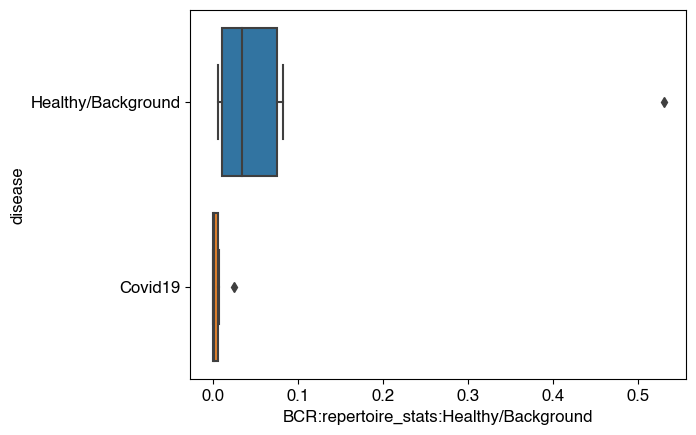

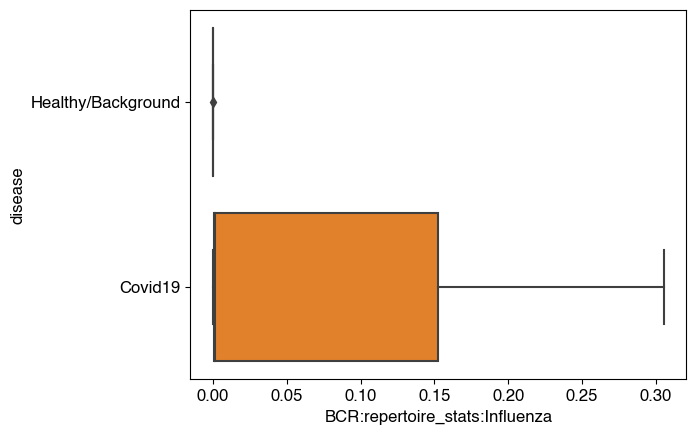

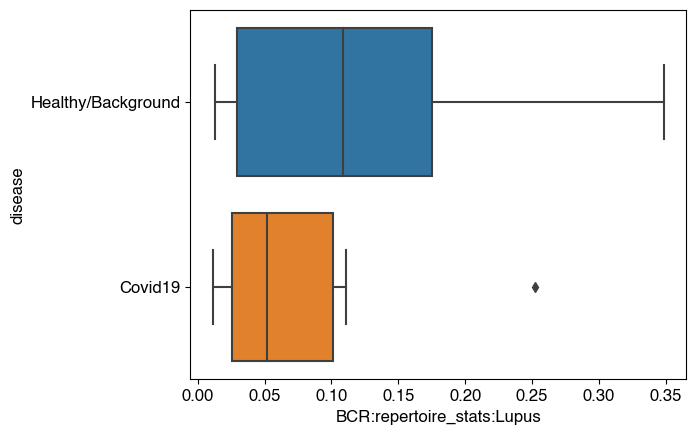

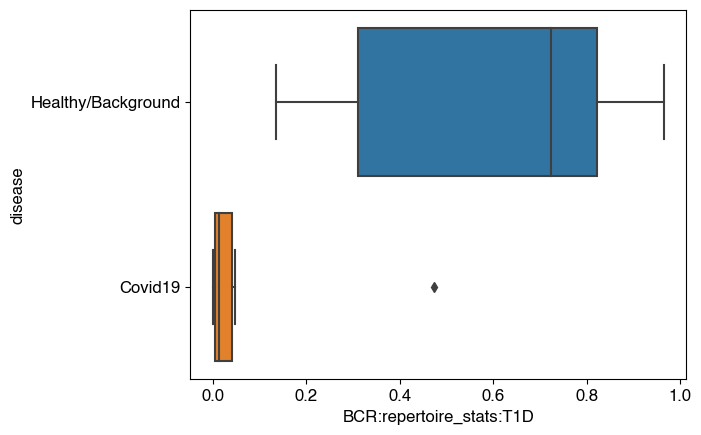

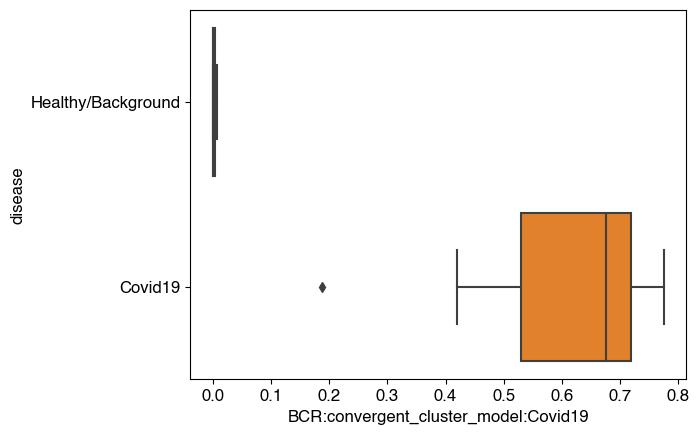

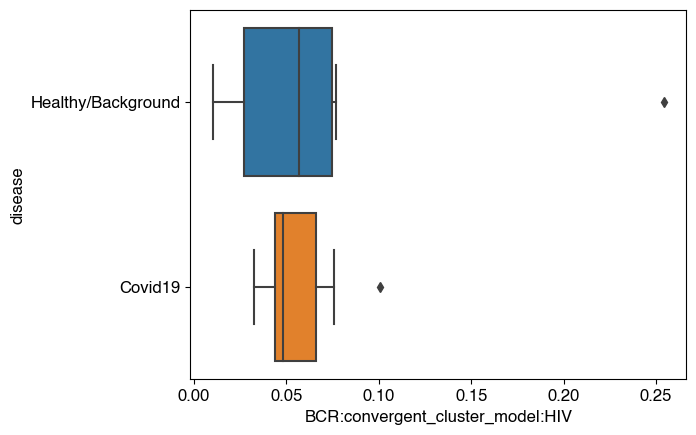

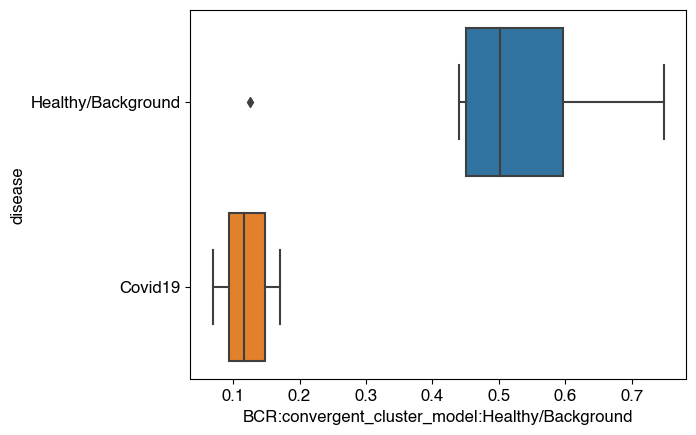

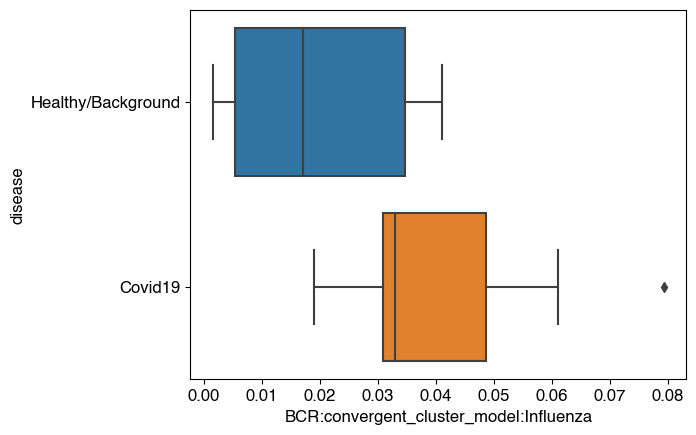

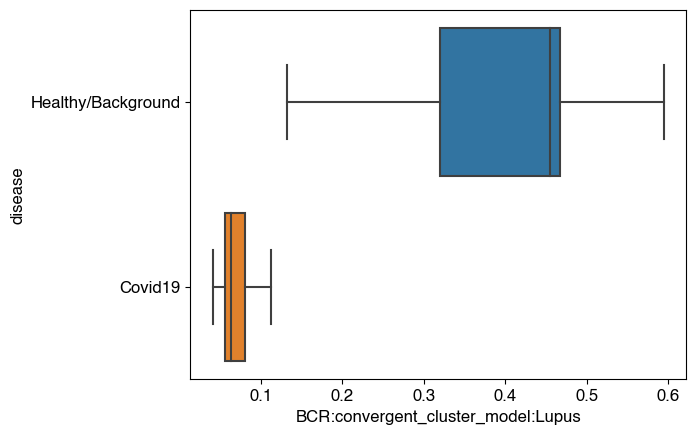

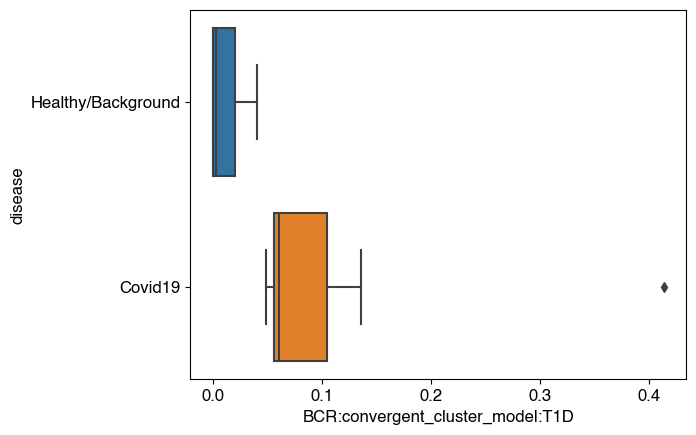

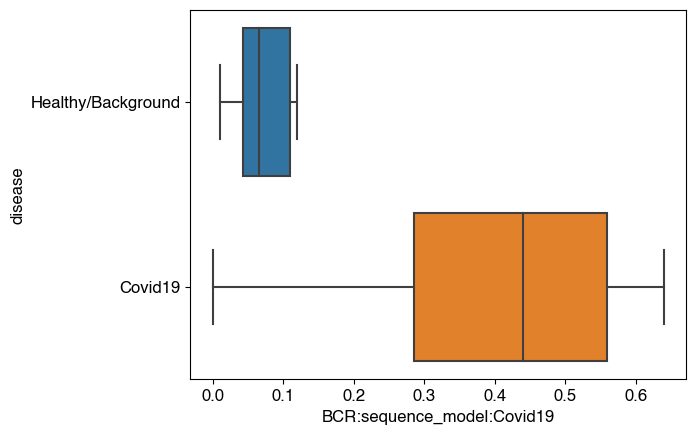

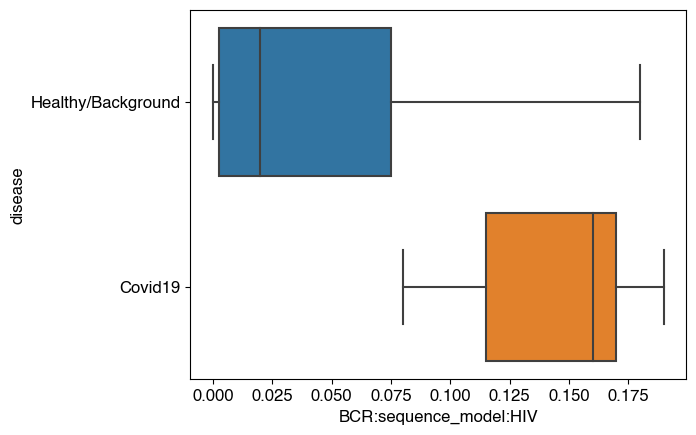

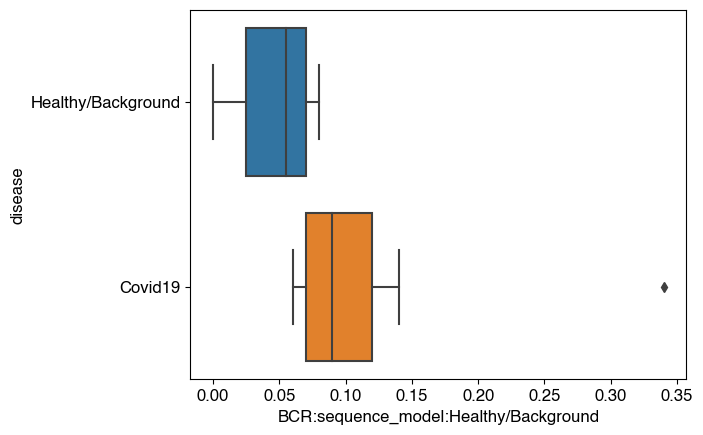

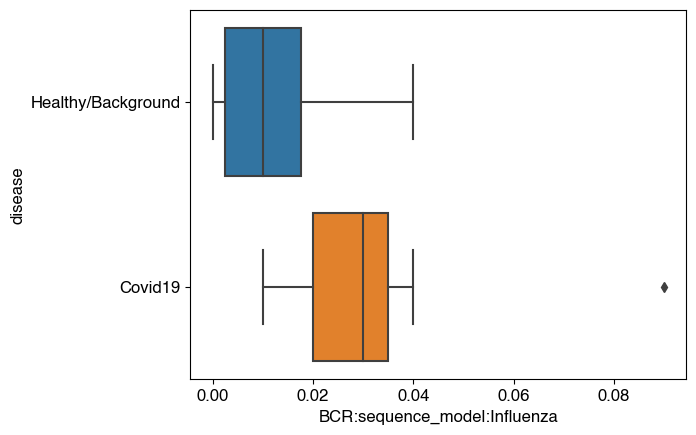

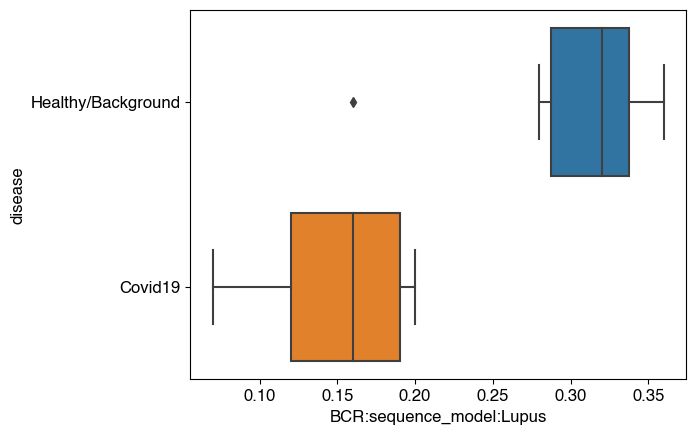

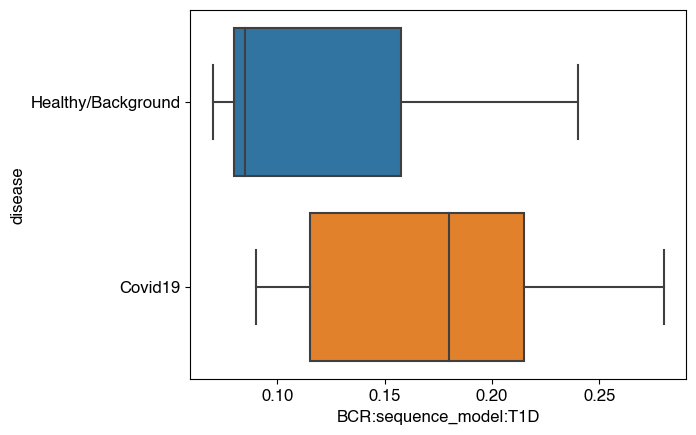

---

### GeneLocus.TCR

TCR:repertoire_stats:Covid19  \
specimen_label                                                       
Britanova_A4-i188                                         0.002264   
Britanova_A4-i101                                         0.007626   
Britanova_A5-S19                                          0.005261   
Shomuradova_6047f706136a6d924982946b                      0.454468   
Britanova_A3-i107                                         0.000155   
Britanova_A6-I200ob                                       0.305941   
Britanova_A3-i102                                         0.020893   
Shomuradova_6047f70a136a6d9249829477                      0.684051   
Britanova_A3-i106                                         0.001778   
Shomuradova_6047f704136a6d9249829462                      0.608174   
Britanova_A4-i102                                         0.006664   
Britanova_A2-i141                                         0.459279   
Britanova_A5-S22                                          0.000054   
Britanova_A4-i185                                         0.009998   
Britanova_A3-i110                                         0.015462   
Britanova_A4-i186                                         0.002473   
Shomuradova_5f07aa8c39579433171763c0                      0.815292   
Britanova_A4-i107                                         0.000005   
Britanova_A4-i110                                         0.000203   
Britanova_A2-i139                                         0.822870   
Britanova_A4-i189                                         0.004939   
Shomuradova_5f07aa8a39579433171763ba                      0.292676   
Shomuradova_6047f704136a6d9249829465                      0.854825   
Britanova_A4-i128                                         0.177556   
Britanova_A4-i194                                         0.000020   
Britanova_A6-I160                                         0.011653   
Shomuradova_6047f70c136a6d924982947f                      0.892048   
Shomuradova_6047f703136a6d924982945f                      0.875185   
Britanova_A4-i124                                         0.000038   
Britanova_A5-S21                                          0.006659   
Britanova_A4-i195                                         0.059446   
Britanova_A4-i192                                         0.001999   
Britanova_A2-i140                                         0.677207   
Britanova_A3-i101                                         0.020809   
Britanova_A6-I215ob                                       0.001724   
Britanova_A6-I202ob                                       0.313610   
Britanova_A4-i191                                         0.000742   
Shomuradova_6047f70b136a6d924982947a                      0.378022   
Shomuradova_6047f70c136a6d924982947d                      0.410885   
Britanova_A4-i106                                         0.050333   
Britanova_A6-I201ob                                       0.266519   
Shomuradova_6047f70d136a6d9249829482                      0.915673   
Shomuradova_6047f708136a6d9249829471                      0.587240   
Britanova_A5-S20                                          0.001201   
Britanova_A5-S24                                          0.000412   
Britanova_A2-i138                                         0.041544   
Britanova_A4-i190                                         0.027675   
Shomuradova_5f07aa8939579433171763b7                      0.564015   
Shomuradova_6047f707136a6d924982946e                      0.640028   
Britanova_A4-i184                                         0.002052   
Britanova_A5-S23                                          0.098572   
Shomuradova_5f07aa8839579433171763b4                      0.257118   
Shomuradova_6047f709136a6d9249829474                      0.659810   
Shomuradova_6047f702136a6d924982945c                      0.459883   
Britanova_A6-I150                                         0.000100   
Britanova_A4-i125                               

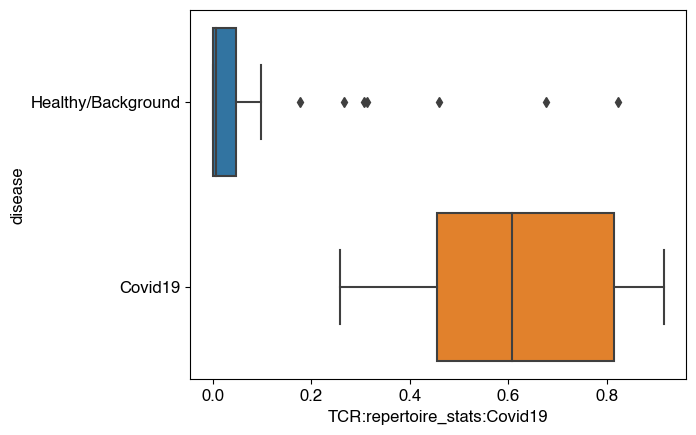

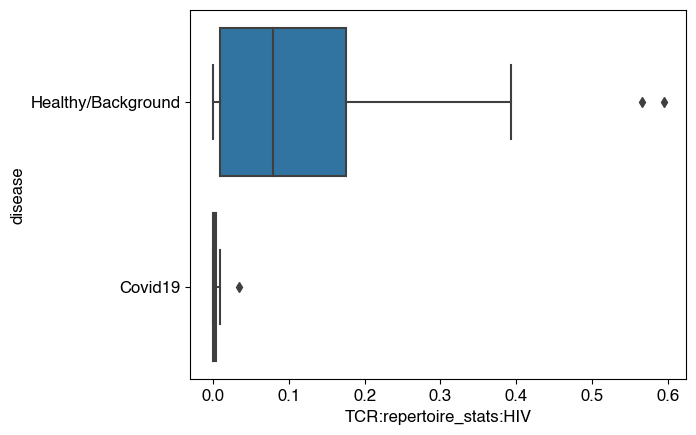

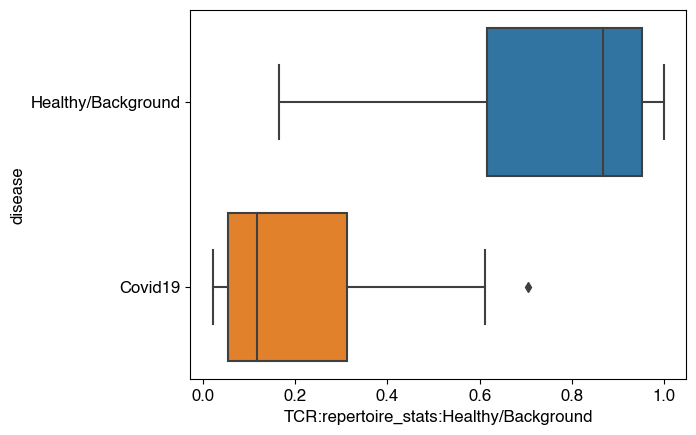

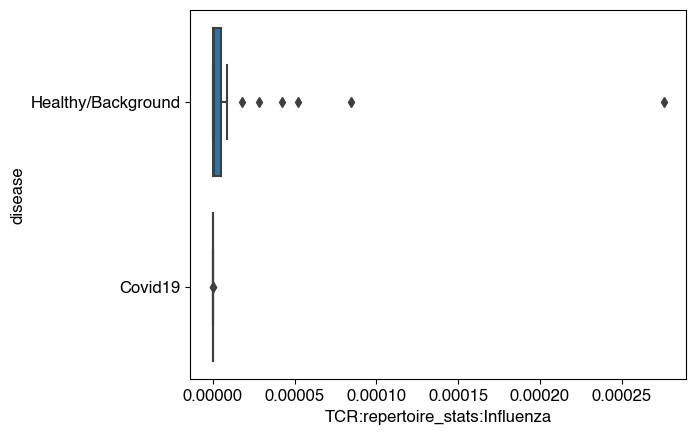

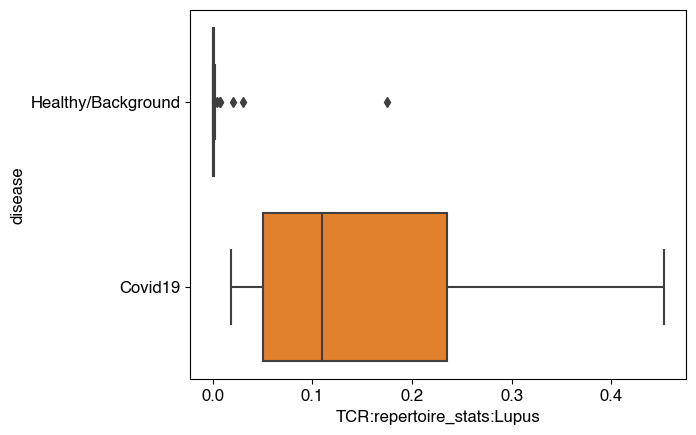

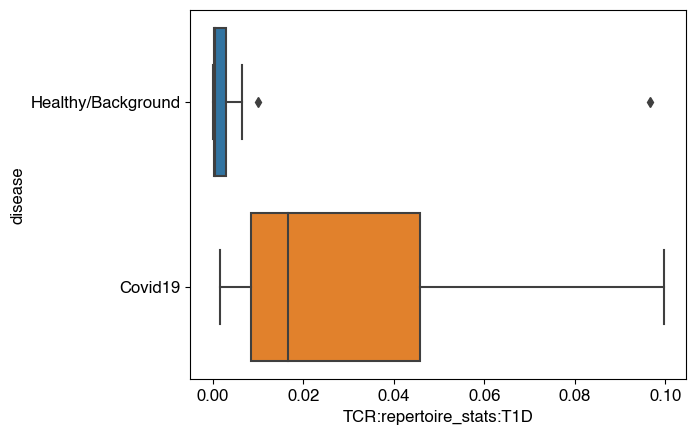

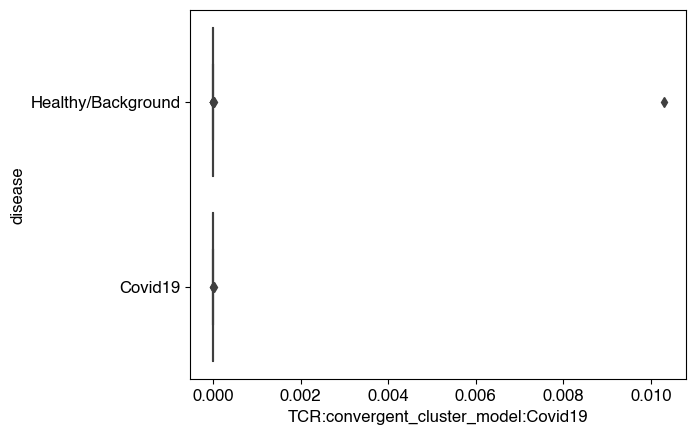

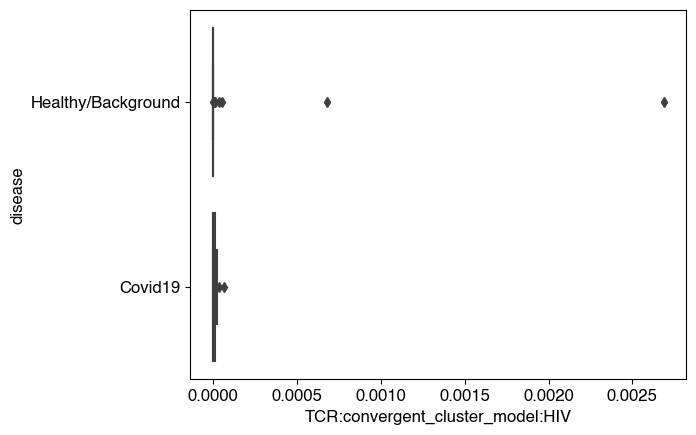

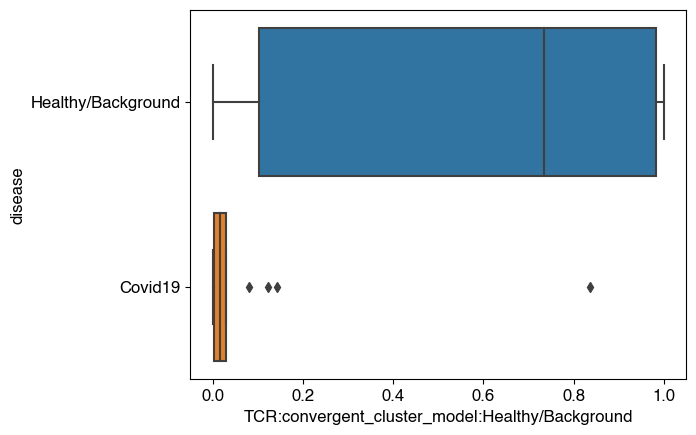

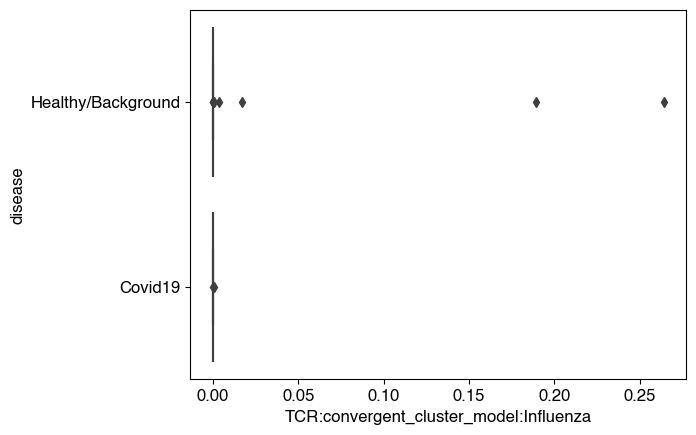

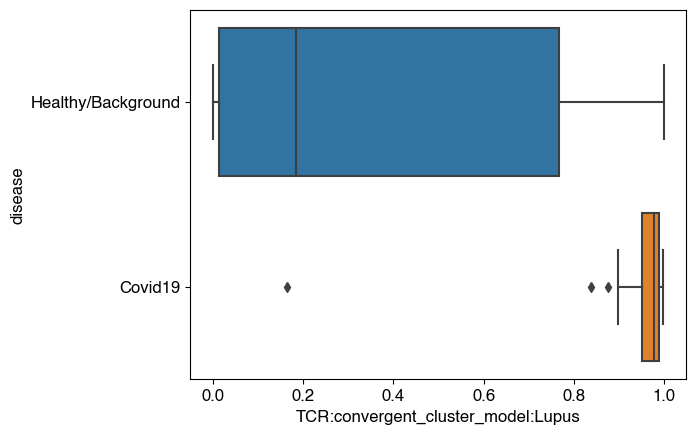

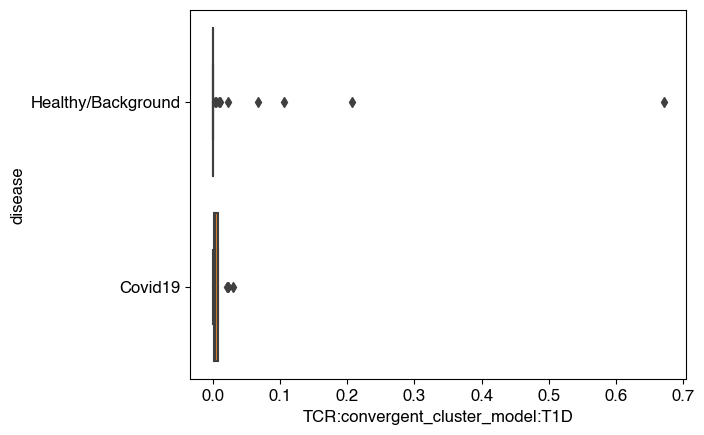

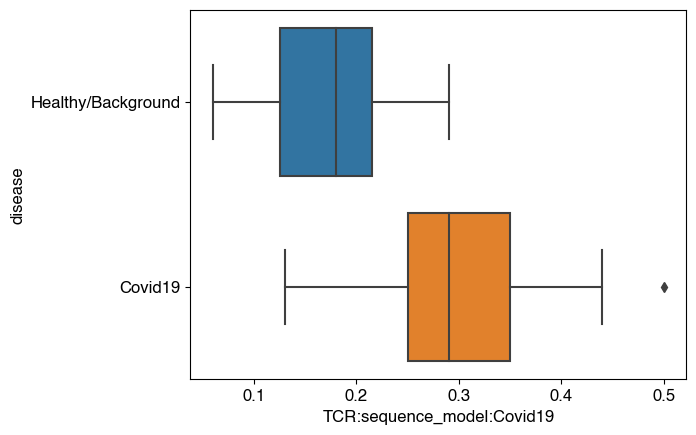

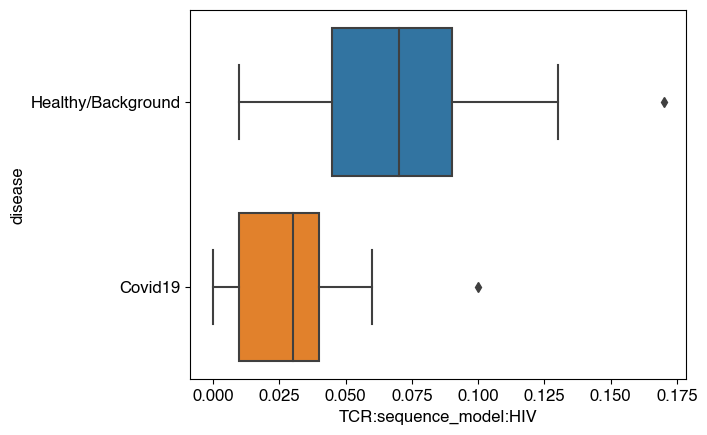

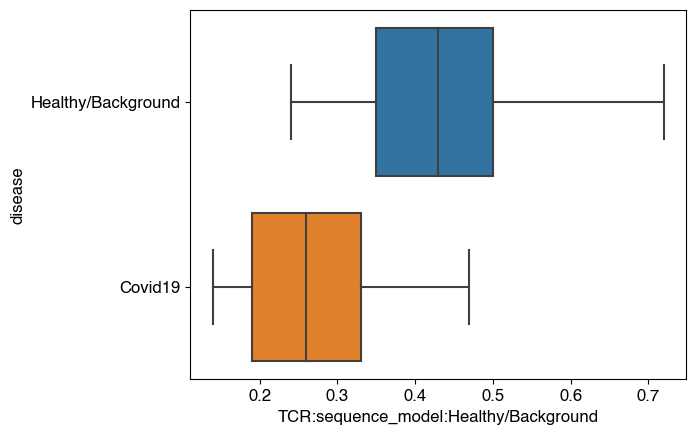

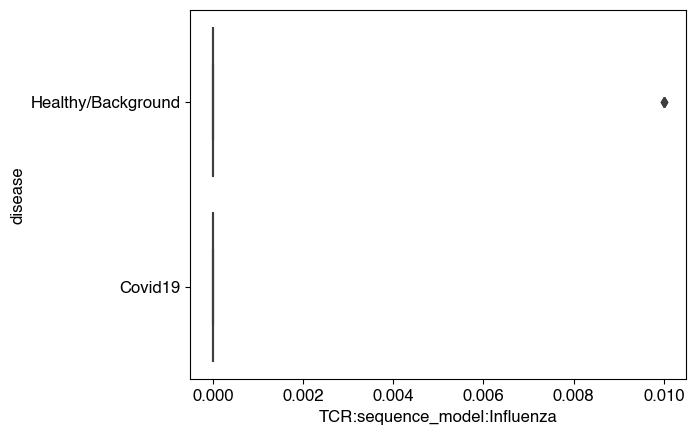

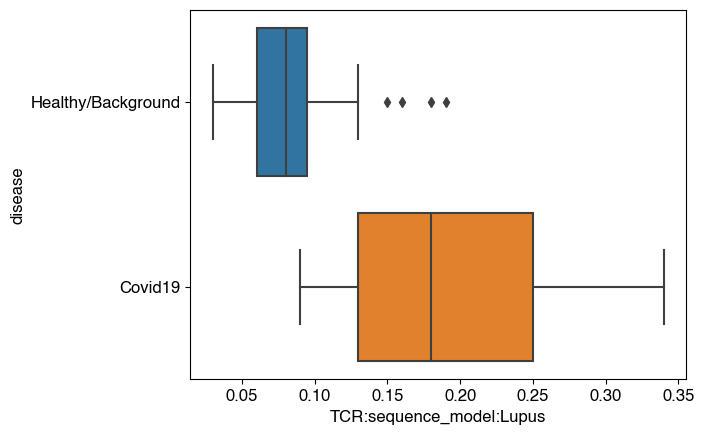

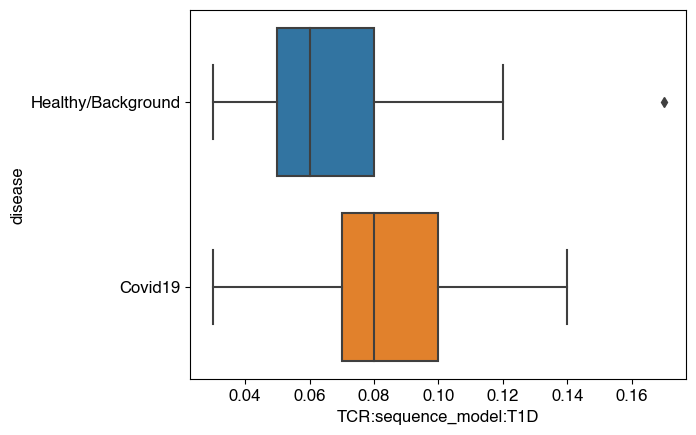

---

In [9]:
# Visualize subcomponent predictions
# (Have to use this awkward kdict notation because GeneLocus flag-enum key is not well handled)
for gene_locus, featurized in featurized_by_gene_locus.items():
    output_dir = (
        config.paths.high_res_outputs_dir
        / "external_cohort_evaluation"
        / "default"
        / gene_locus.name
    )
    output_dir.mkdir(parents=True, exist_ok=True)

    display(Markdown(f"### {gene_locus}"))
    display(featurized.X)

    for col in featurized.X.columns:
        fig = plt.figure()
        sns.boxplot(
            data=pd.concat([featurized.X[col], featurized.metadata], axis=1),
            x=col,
            y="disease",
        )
        genetools.plots.savefig(
            fig, output_dir / f"subcomponent.{slugify(col)}.png", dpi=300
        )
        display(fig)
        plt.close(fig)
    display(Markdown("---"))